## 1. Data loading and cleaning

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import re
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
from itertools import chain, combinations
from joblib import Memory
from shutil import rmtree

from IPython.display import display_html, display
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as sps
from scipy.sparse import csr_matrix, hstack, vstack

from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectFromModel, mutual_info_classif
from sklearn.inspection import permutation_importance
from sklearn.linear_model import SGDClassifier, LogisticRegression, LogisticRegressionCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline

from mlxtend.feature_selection import SequentialFeatureSelector
import eli5

import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [ ]:
os.chdir('C:\\Users\\Yury\\Downloads\\assignments\\tableau_stuff\\notebooks\\project alice')

In [2]:
# Let's mark the folder with the notebook data
PATH_TO_DATA = 'capstone_user_identification'

First we read the dictionary containing the sites
and the corresponding numbers and invert it.

In [3]:
with open(os.path.join(PATH_TO_DATA, 'site_dic.pkl'), 'rb') as s:
    site_dict = pickle.load(s)
site_dict = {v: k for k, v in site_dict.items()}
site_dict[0] = 'unknown'

Let's read the data. We will sort the rows in the train
dataframe because the data has temporal structure we would like
to preserve (similar to what one does when analyzing time series).

In [4]:
sites = [f'site{i}' for i in range (1, 11)]
times = [f'time{i}' for i in range (1, 10)]

train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'),
                       index_col='session_id', parse_dates=times)
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'),
                      index_col='session_id', parse_dates=times)

train_df.sort_values(by='time1', inplace=True)

In [5]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaN,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaN,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0


Before constructing additional features and analyzing the data
we should preprocess it, that is, check for omissions, wrong entries
and clean it.

In [6]:
pd.DataFrame([train_df.isna().sum(), test_df.isna().sum()]).\
    T.rename(columns={0: 'train', 1: 'test'})

,train,test
site1,0.0,0.0
time1,0.0,0.0
site2,3463.0,1489.0
time2,3463.0,1489.0
site3,6642.0,2722.0
time3,6642.0,2722.0
site4,9240.0,3615.0
time4,9240.0,3615.0
site5,11732.0,4456.0
time5,11732.0,4456.0


In [7]:
1

1

So some of the sessions are not complete. We substitute the empty sites with zeros.

In [8]:
train_df[sites] = train_df[sites].fillna(0).astype(int)
test_df[sites] = test_df[sites].fillna(0).astype(int)

Let us check if the temporal structure of the sessions is ok.

In [9]:
train_df.time1.min(), train_df.time1.max(),\
test_df.time1.min(), test_df.time1.max()

(Timestamp('2013-01-12 08:05:57'),
 Timestamp('2014-04-30 23:39:53'),
 Timestamp('2014-05-01 17:14:03'),
 Timestamp('2014-12-05 23:26:53'))

The train and test data are separated by time, as expected.

Let us check the distribution of the sessions with respect
to days of months:

In [10]:
train_test_df = pd.concat([train_df, test_df])
train_test_df['year'] = train_test_df.time1.dt.year
train_test_df['month'] = train_test_df.time1.dt.month
train_test_df['day_of_month'] = train_test_df.time1.dt.day


day_of_month_distr = pd.crosstab(
    index=[train_test_df.year, train_test_df.month],
    columns=train_test_df.day_of_month
    )
day_of_month_distr.query('year == 2013').T

year         2013                                                            \
month          1     2     3     4     5     6    7    8     9     10    11   
day_of_month                                                                  
1               0     0     0     0     0     0    0    0     0     0     0   
2               0     0     0     0     0     0    0    0     0     0     0   
3               0     0     0     0     0     0    0    0     0     0     0   
4               0     0     0     0     0     0    0    0     0     0     0   
5               0     0     0     0     0     0    0    0     0     0     0   
12            363  3929  3337  3997  3229  2094  139  290  3464  2788  3375   
13              0     0     0     0     0     0    0    0     0     0     0   
14              0     0     0     0     0     0    0    0     0     0     0   
15              0     0     0     0     0     0    0    0     0     0  2541   
16              0     0     0     0     0     0    0    0     0     0   366   
17              0     0     0     0     0     0    0    0     0     0   316   
18              0     0     0     0     0     0    0    0     0     0  1410   
19              0     0     0     0     0     0    0    0     0     0  2709   
20              0     0     0     0     0     0    0    0     0     0  3296   
21              0     0     0     0     0     0    0    0     0     0  3458   
22              0     0     0     0     0     0    0    0     0     0  2421   
23              0     0     0     0     0     0    0    0     0     0   326   
24              0     0     0     0     0     0    0    0     0     0   443   
25              0     0     0     0     0     0    0    0     0     0  4510   
26              0     0     0     0     0     0    0    0     0     0  2526   
27              0     0     0     0     0     0    0    0     0     0  2779   
28              0     0     0     0     0     0    0    0     0     0  1311   
29              0     0     0     0     0     0    0    0     0     0  2488   
30              0     0     0     0     0     0    0    0     0     0   218   
31              0     0     0     0     0     0    0    0     0     0     0   

year                
month           12  
day_of_month        
1                0  
2                0  
3                0  
4                0  
5                0  
12            2391  
13            2660  
14             333  
15             258  
16            1948  
17            1639  
18            3449  
19            2010  
20            1272  
21             106  
22             128  
23              98  
24              60  
25               0  
26             110  
27              44  
28              45  
29               0  
30               0  
31               1

In [11]:
day_of_month_distr.query('year == 2014').T

year          2014                                                        \
month           1     2     3     4     5     6     7     8     9     10   
day_of_month                                                               
1                0     1     0     1     1  1527   474  1570  1564   674   
2              952   142  1196  2609  4386  2020  1746  1411   154  3807   
3             1095   118   865  2380  4310     0  4528   748   247    41   
4             5732  7045  3368  4060  1351   437  3712  4101  1447  3524   
5               34    48     4     1   304   381   377    16   215   111   
12               0     0     0     0     0     0     0     0     0     0   
13             991  4322   161   227  2034     0     0     0     0     0   
14            1060  2306    97  4084  2985     0     0     0     0     0   
15             985     0   220  2015  1141     0     0     0     0     0   
16             699    34   349  2994   954     0     0     0     0     0   
17             961  3309  4742  2884    37     0     0     0     0     0   
18              70  3641  1720  1687    77     0     0     0     0     0   
19             161  6361  7896    43  1902     0     0     0     0     0   
20            2360  3015  3538    21  1106     0     0     0     0     0   
21            1717  1760  4389    76   747     0     0     0     0     0   
22            4077  1775  1129   783   866     0     0     0     0     0   
23             729   217   149  1132   699     0     0     0     0     0   
24             676  4099  3343  2728   169     0     0     0     0     0   
25            1421  3570  3619  2227   117     0     0     0     0     0   
26              84  7807  6140   119   608     0     0     0     0     0   
27            2323  3327  4976   110   887     0     0     0     0     0   
28            2234  2666  1762   337   999     0     0     0     0     0   
29            3924     0   743   310     0     0     0     0     0     0   
30            1692     0   234   376     0     0     0     0     0     0   
31            1892     0  5610     0     0     0     0     0     0     0   

year                      
month           11    12  
day_of_month              
1               41    12  
2             6337  7022  
3               70   226  
4             3432   190  
5               17  4938  
12               0     0  
13               0     0  
14               0     0  
15               0     0  
16               0     0  
17               0     0  
18               0     0  
19               0     0  
20               0     0  
21               0     0  
22               0     0  
23               0     0  
24               0     0  
25               0     0  
26               0     0  
27               0     0  
28               0     0  
29               0     0  
30               0     0  
31               0     0

We see that in January-November 2013 there are only sessions
 that begin on the day 12. Similarly, for 2014 there are no sessions
 for the days 5-12 of each month, and the test data is collected only
 on the days 1-5 of the months 6-12. This probably suggests that there
 was an error while obtaining the dates, that is, some of them were
 written in the format YYYY-DD-MM instead of YYYY-MM-DD. Correcting
 the dates, we get two things:

 1. The potential 'month' feature becomes useful;
 2. Our classification becomes an interpolation task (with respect to time) instead of an extrapolation, which is very nice when dealing with time-series-alike problems.

In [12]:
def fix_incorrect_date_formats(df, columns_to_fix):
    for time in columns_to_fix:
        d = df[time]
        d_fix = d[d.dt.day <= 12]
        d_fix = pd.to_datetime(d_fix.apply(str), format='%Y-%d-%m %H:%M:%S')
        df.loc[d_fix.index.values, time] = d_fix
    return df

train_df = fix_incorrect_date_formats(train_df, times)
test_df = fix_incorrect_date_formats(test_df, times)

train_df.sort_values(by='time1', inplace=True)

y = train_df.target
train_df.drop('target', axis=1, inplace=True)

As for the sites:
 - we will clean the URLs by removing the (probably unnecessary) parts such as "http://www.", thus joining some of the different sites together;
 - we will glue the sites that are on the same domain of level 3 (there are many sites in the dictionary like 'i1-js-14-3-01-11074-190330828-i.init.cedexis-radar.net', 'i1-js-14-3-01-11074-844105972-i.init.cedexis-radar.net' and so on which can probably be mapped just to 'init.cedexis-radar.net')

In [13]:
url_begin_expr = r"^\S*?\.*?www\S*?\."

shorten_site = lambda site: '.'.join(site.split('.')[-3:]) if len(site.split('.')) > 3 else site 
# tear off everything above 3rd-level domain

site_dict1 = {k: re.sub(url_begin_expr, '', v) for k, v in site_dict.items()}
reduced_site_set = list(set(site_dict1.values()))
print(f'Reduced the number of sites from {len(site_dict)} to {len(reduced_site_set)}')

index_of_unknown = reduced_site_set.index('unknown')
reduced_site_set[0], reduced_site_set[index_of_unknown] = reduced_site_set[index_of_unknown], reduced_site_set[0]
# a little change so that the index of (no site) is still 0

site_dict2 = dict(zip(reduced_site_set, range(len(reduced_site_set)))) # reindexing the reduced sites set
site_dict3 = {k: site_dict2[site_dict1[k]] for k in site_dict.keys()} # mapping the keys of the original site_dict
# to the new keys (some of the keys map to the same key)

for df in train_df, test_df:
    df[sites] = df[sites].applymap(lambda site: site_dict3[site]).astype(int)
    
site_dict = {v: k for k, v in site_dict2.items()} # the final dictionary is the reverse of site_dict2
del site_dict1, site_dict2, site_dict3

Reduced the number of sites from 48372 to 47135


## 2. Data model, feature enginieering and initial analysis

We will consider the sessions as phrases in a language
where the sites URLs are words, and will use the
"bag of words" model to represent a session as a sparse
vector. In order to preserve the ordering data we will also
 capture $n$-grams of sites for $n \le 5$ (alternatively,
 we can consider the maximal $n$ as a hyperparameter and
 tune it at cross-validation). To emphasize the more
 important sites (and $n$-grams of sites) and ignore
 the less important we vectorize the sessions by Tf-idf
 and cut the number of features by 50000.

In [14]:
%%time
vectorizer_params={'ngram_range': (1, 5),
                       'max_features': 50000,
                       'tokenizer': lambda s: s.split()}

def vectorize_sites(train_df, test_df, params):
    """Transform the sessions into sentences of the sites, fit a Tf-Idf vectorizer
    on the train data sessions and transform the test data sessions."""
    train_sessions = train_df[sites].apply(lambda row: ' '.join(site_dict[idx]  for idx in row), axis=1)
    test_sessions = test_df[sites].apply(lambda row: ' '.join(site_dict[idx]  for idx in row), axis=1)

    vectorizer = TfidfVectorizer(**params)
    train_sessions = vectorizer.fit_transform(train_sessions)
    test_sessions = vectorizer.transform(test_sessions)

    return vectorizer, train_sessions, test_sessions


tf_idf, X_train_sparse, X_test_sparse = vectorize_sites(train_df, test_df, vectorizer_params)
site_features = tf_idf.get_feature_names()

Wall time: 1min 10s


Let's see the distributuion of the target variable:

In [15]:
y.value_counts()

0    251264
1      2297
Name: target, dtype: int64

So the classes are highly unbalanced. This means that the accuracy metric won't be adequate and we'll have to use ROC-AUC or something similar.

Now let's introduce additional features and analyze them. We begin with features related to sites. We extract the following features:

 - Number of sites in a session which are in the Alice's top 20;
 - Number of sites in a session which are in the Alice's top 20 but not the others' (we could also min-max normalize the list of top only Alice sites by the number of visits and consider a weighted sum);
 - Number of sites in a session which are in top 30 sites;
 - Number of unique sites in a session;
 - Total number of sites in session;
 - Average number of Alice's top visited sites;
 - Number of sites from top 30 in a session;
 - Average length of a site as a word.
 
 The numbers 20 and 30 are chosen arbitrarily and can be tuned.

In [16]:
top_alice_sites = pd.Series(train_df.loc[y == 1, sites].values.flatten()).\
    value_counts(ascending=False).head(40)
top_not_alice_sites = pd.Series(train_df.loc[y == 0, sites].values.flatten()).\
    value_counts(ascending=False).head(40)
top_only_alice_sites = top_alice_sites[list(set(top_alice_sites.index) -
                                            set(top_not_alice_sites.index))].sort_values(ascending=False)
    # this way we get 20 sites which are in Alice's top but not the others'
    
top_alice_sites = pd.Series(train_df.loc[y == 1, sites].values.flatten()).\
    value_counts(ascending=False).head(20)
num_top_sites = 30
top_sites = pd.Series(train_df[sites].values.ravel()).value_counts().head(num_top_sites + 1).drop(0)

for df in (train_df, test_df):
    df['num_only_alice_sites'] = np.isin(df[sites], top_only_alice_sites.index).sum(axis=1)
    df['num_alice_sites'] = np.isin(df[sites], top_alice_sites.index).sum(axis=1)
    df['num_unique_sites'] = df[sites][df[sites] != 0].nunique(axis=1)
    df['num_sites'] = df[sites][df[sites] != 0].count(axis=1)
    df['avg_alice_sites'] = df.num_alice_sites / df.num_sites
    df['num_top_sites'] = np.isin(df[sites], top_sites.index).sum(axis=1)
    df['sites_len'] = df[sites].apply(
        lambda session: np.mean([len(site_dict[site_idx]) for site_idx in session.values if site_idx != 0]),
        axis=1)

In [17]:
train_df[sites].head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
27554,46650,43160,43160,46650,32645,32645,43160,46650,32645,43160
81350,32645,46650,32645,43160,46650,32645,32645,43160,46650,32645
234665,15856,2329,34863,1329,1329,16959,16959,21016,2329,30729
97610,2329,2329,30729,21016,19510,44261,8944,16959,16959,8944
161358,32645,32645,43160,46650,32645,0,0,0,0,0


The second group of features are related to time. Here we extract the following features:
 - Linear time (normalized) up to a day
 - Month and day of the week
 - Total session timespan
 - Average time spent on a site in seconds
 - Start hour of a session
 - Sine and cosine of the start hour (may be useful since we are going to use a linear model and the hour feature is cyclic)

In [18]:
month_days = {1: 31, 2:28, 3:31, 4: 30, 5: 31, 6:30, 7: 31, 8:31, 9:30, 10:31, 11:30, 12:31}
for df in (train_df, test_df):
    df['yyyymmdd'] = df.time1.map((lambda timestamp: (12 * (timestamp.year - 2013) + timestamp.month - 1 + 
                                                     timestamp.day / month_days[timestamp.month]) / 10))
    df['month'] = df.time1.dt.month
    df['day_of_week'] = df.time1.dt.dayofweek
    df['session_timespan'] = (df[times].max(axis=1) - df[times].min(axis=1)).dt.seconds
    df['avg_time_on_site'] = (df[times].max(axis=1) - df[times].min(axis=1)).dt.seconds / df.num_sites
    df['start_hour'] = (df.time1.dt.hour % 24)
    df['hour_cos'] = np.cos(2 * np.pi * df.time1.dt.hour / 24)
    df['hour_sin'] = np.sin(2 * np.pi * df.time1.dt.hour / 24)

First of all, as we're going to use a linear model, we will need normalized features. The only features which can achieve arbitrary high values are the length and the average length of a session. Let's look at their plots:

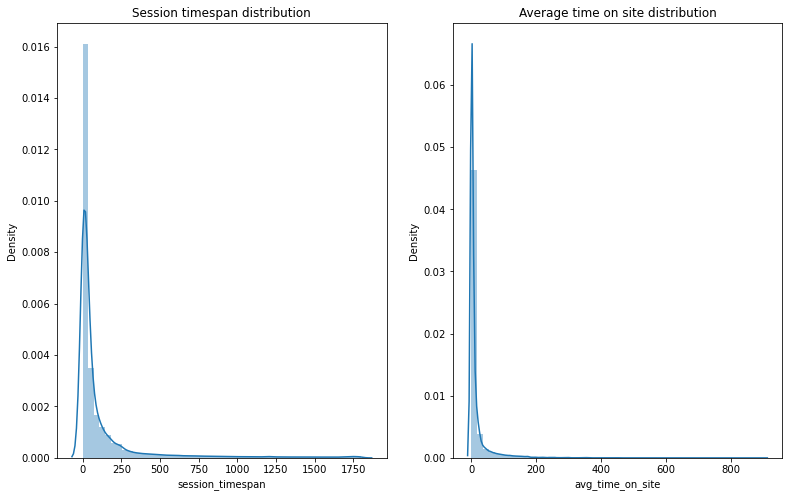

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(13, 8))
sns.distplot(train_df['session_timespan'], ax=ax[0])
sns.distplot(train_df['avg_time_on_site'], ax=ax[1])

ax[0].set_title('Session timespan distribution')
ax[1].set_title('Average time on site distribution');

So the variables are indeed highly skewed. To deal with this, we will log-normalize them.

In [20]:
for df in train_df, test_df:
    df['session_timespan'] = np.log1p(df['session_timespan'])
    df['avg_time_on_site'] = np.log1p(df['avg_time_on_site'])

Before doing graphical data analysis, let's check if the introduced features are independent (by Spearman pairwise correlation).

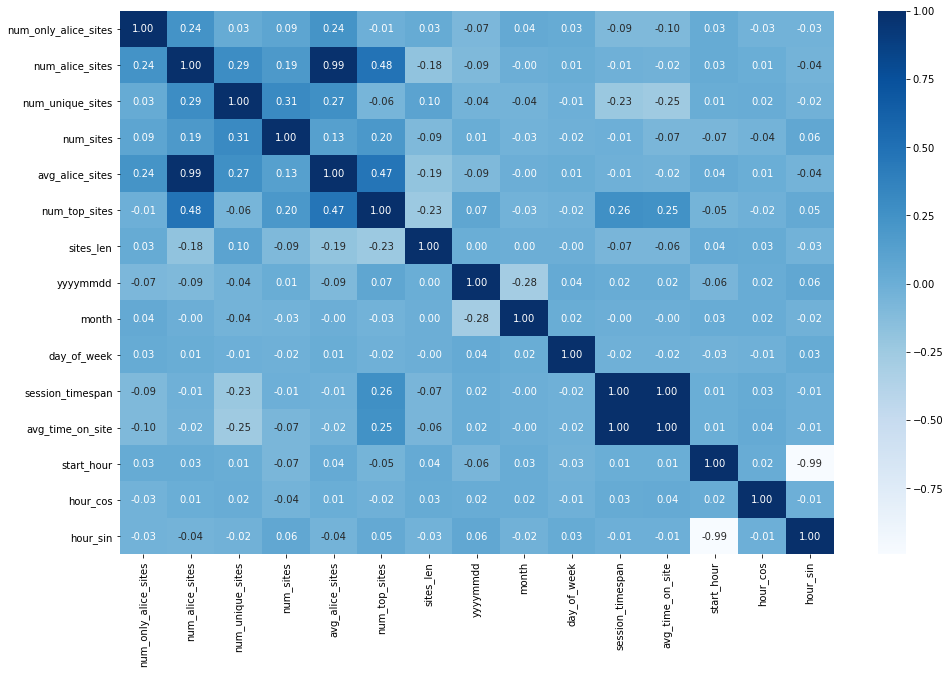

In [21]:
plt.figure(figsize = (16, 10)) 
sns.heatmap(train_df.iloc[:, 20:].corr('spearman'), annot=True, fmt='.2f', cmap='Blues');

Based on the correlation matrix, we can safely exclude ```avg_alice_sites```, ```avg_time_on_site``` and ```hour_sin``` features (the last on correlating with the start hour means that the majority of the sessions begin during the day where the function $\sin(hour)$ behaves almost linearly, as we will see later). We will drop ```hour_cos``` as well. Some of the site features also show relatively big correlation so we'll have to be careful with them later.

In [22]:
to_drop = ['avg_alice_sites', 'avg_time_on_site', 'hour_sin', 'hour_cos']
for df in train_df, test_df:
    df.drop(to_drop, axis=1, inplace=True)

Let's draw some plots now! We will see if some features that we introduced indeed separate the two classes. Let's begin with the linear time:

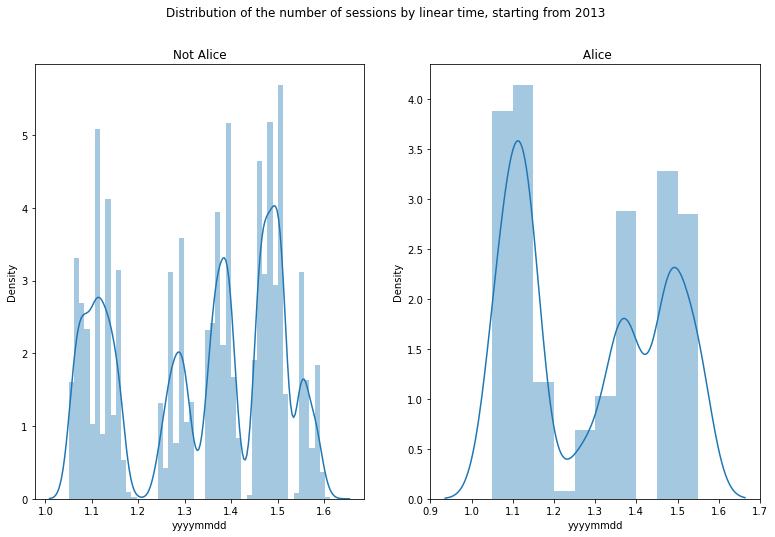

In [23]:
def plot_feature(feature, plot=sns.countplot, description=None):
    fig, ax = plt.subplots(1, 2, figsize=(13, 8))
    for i in [0, 1]:
        plot(train_df.loc[y == i, feature], ax=ax[i])
        ax[i].set_title('Not' * (1 - i) + ' Alice')

    if description is None:    
        plt.suptitle(f'Distribution of {feature} according to the feature class')
    else:
        plt.suptitle(description);

plot_feature('yyyymmdd', sns.distplot, 'Distribution of the number of sessions by linear time, starting from 2013')

Well, at least it doesn't look like there is a linear dependence between the time and the target variable. So we'll probably have to discard this feature and binarize other linear time features, such as 'month'. Let's look at the weekday now:

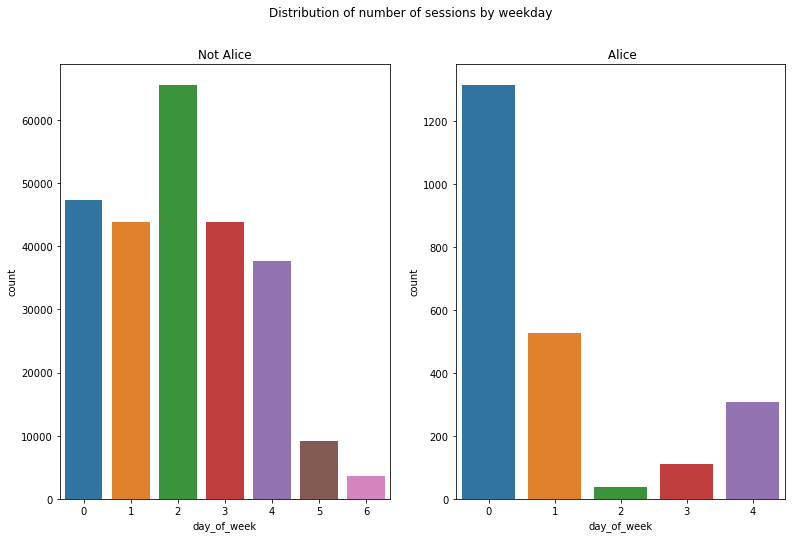

In [24]:
plot_feature('day_of_week', description='Distribution of number of sessions by weekday')

So we see that Alice has no sessions during the weekend, and almost no sessions during Wednesday, so we might want to binarize the 'day' feature and extract these days as explicit features. Let's look at the hour feature:

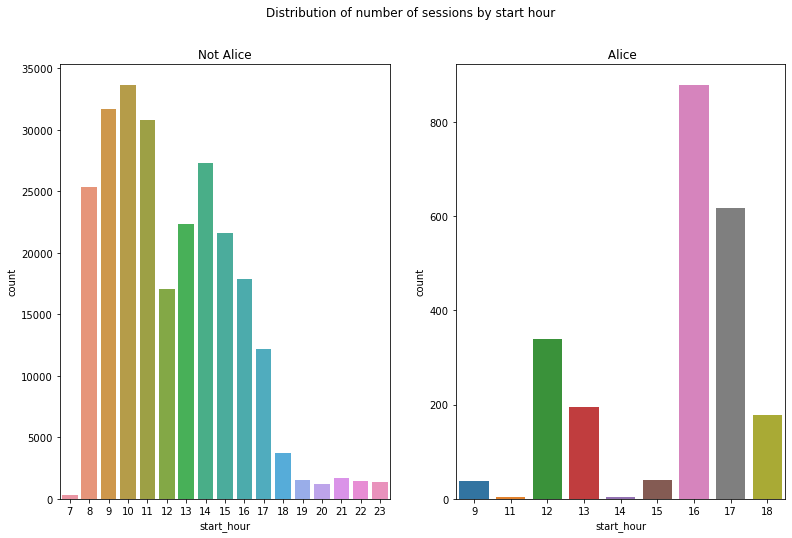

In [25]:
plot_feature('start_hour', description='Distribution of number of sessions by start hour')

So Alice isn't active before 9 (almost no activity until noon, in fact) and after 19. So perhaps it's better to binarize this feature as well. Let's look at the normalized session timespan:

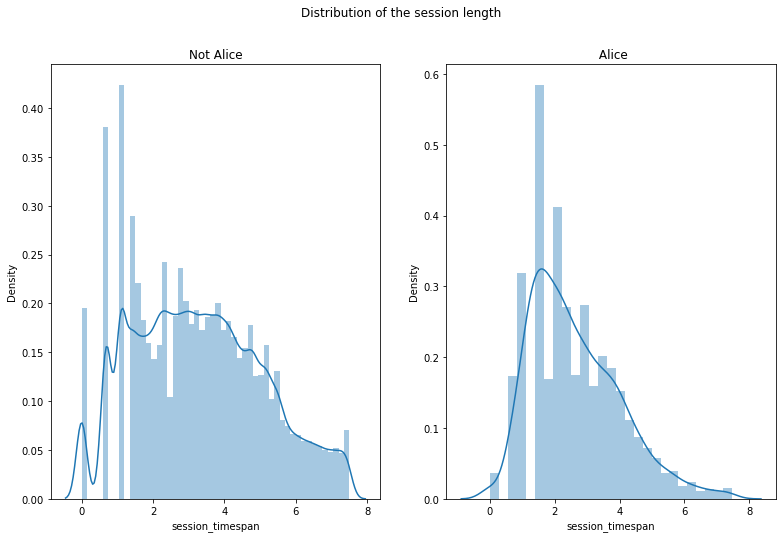

In [26]:
plot_feature('session_timespan', plot=sns.distplot, description='Distribution of the session length')

It appears that Alice's sessions are generally a bit shorter. Now let's look at the site features:

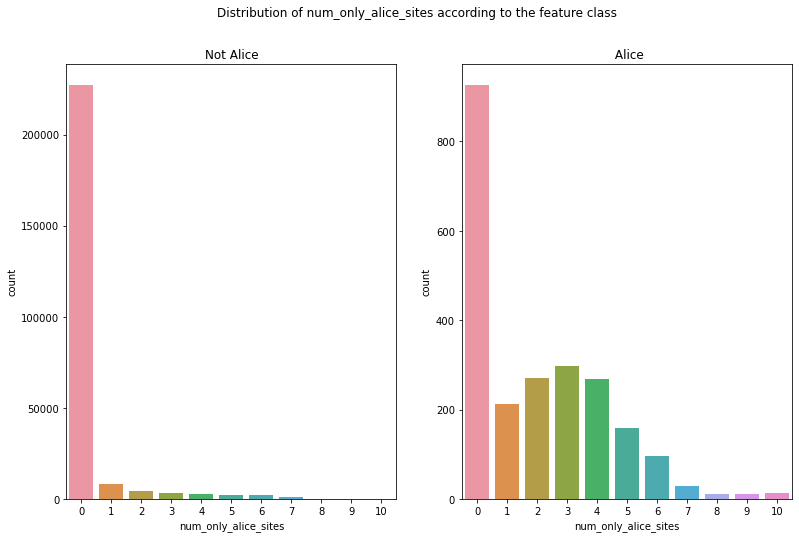

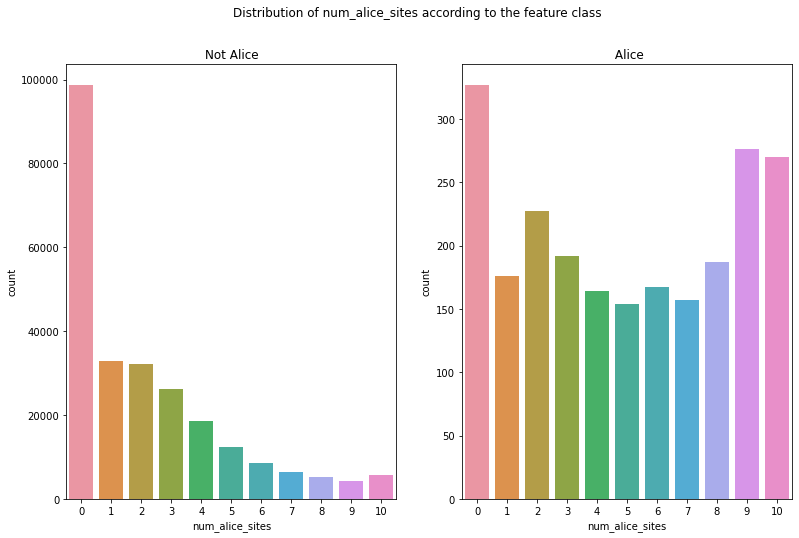

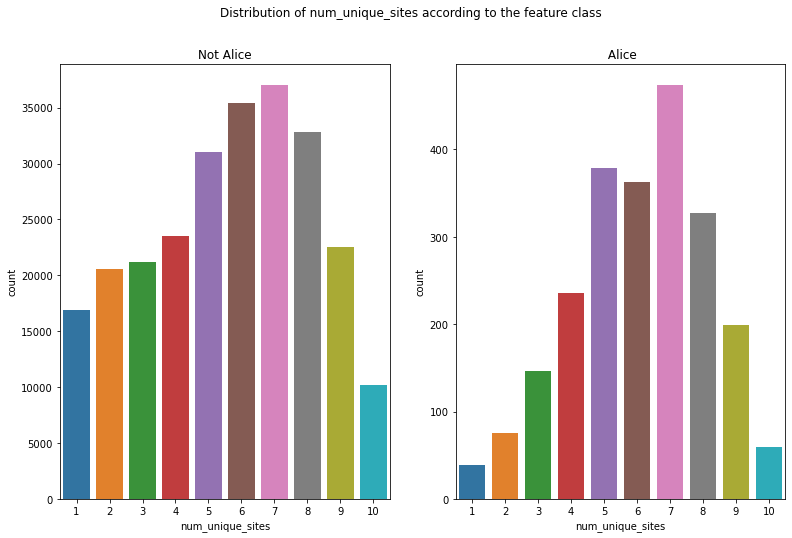

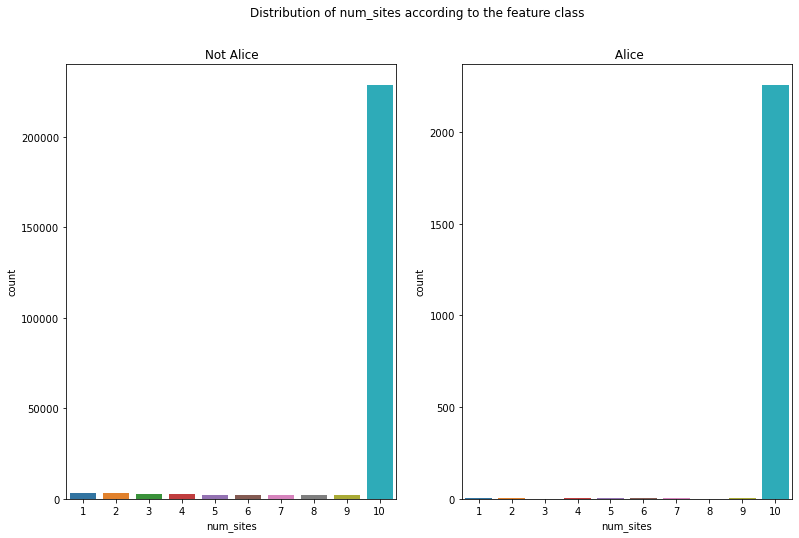

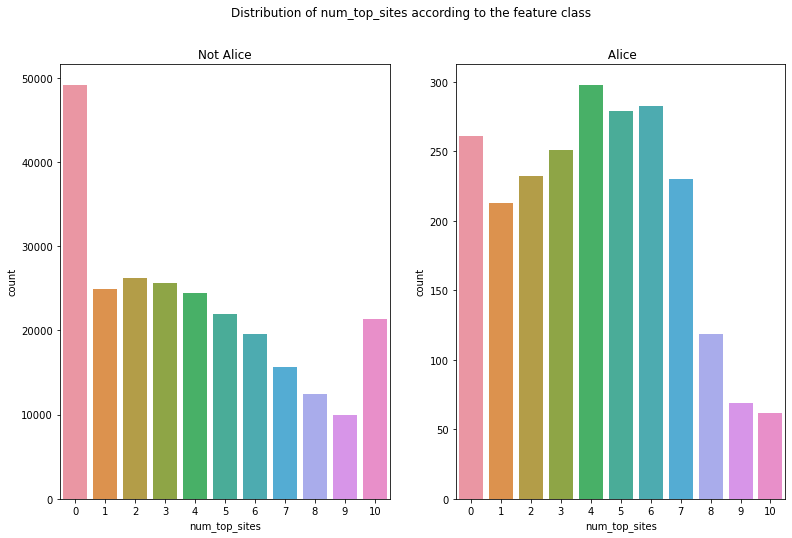

In [27]:
add_site_features = ['num_only_alice_sites', 'num_alice_sites', 
                 'num_unique_sites', 'num_sites', 'num_top_sites']

for feature in add_site_features:
    plot_feature(feature)

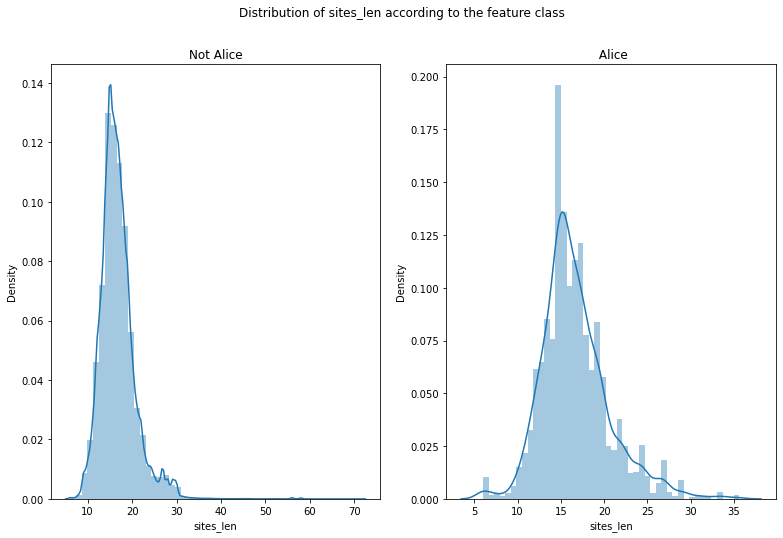

In [28]:
plot_feature('sites_len', plot=sns.distplot)

The visual analysis suggests that the features related with number of sites from certain groups distinguish the two classes more clearly.

Now let us update the time features: we delete the linear time and binarize the cyclic time features such as month and hour. We also group some of the features together: for example, there is no point in making two separate features for two weekend days. We will also make features for time of the day (for example, for the period of 12-13 and 16-18 hours, because Alice is more active on this period. Grouping hour features may also reduce overfitting), excluding night, because there are no sessions that begin at night.

In [29]:
for df in train_df, test_df:
    df.drop(columns='yyyymmdd', inplace=True)

In [30]:
columns_to_dummies = ['start_hour','day_of_week', 'month']
train_df = pd.get_dummies(train_df, columns=columns_to_dummies, drop_first=True)
test_df = pd.get_dummies(test_df, columns=columns_to_dummies, drop_first=True)

In [31]:
for df in train_df, test_df:
    df['12-13'] = ((12 <= df.time1.dt.hour) & (df.time1.dt.hour <= 13)).astype(int)
    df['16-18'] = ((16 <= df.time1.dt.hour) & (df.time1.dt.hour <= 18)).astype(int)
    df['morning'] = ((7 <= df.time1.dt.hour) & (df.time1.dt.hour <= 11)).astype(int)
    df['day'] = ((12 <= df.time1.dt.hour) & (df.time1.dt.hour <= 18)).astype(int)
    df['evening'] = ((19 <= df.time1.dt.hour) & (df.time1.dt.hour <= 24)).astype(int)
    df['is_weekend'] = df.day_of_week_5 + df.day_of_week_6 

In [32]:
for df in train_df, test_df:
    df.drop(columns=['day_of_week_5', 'day_of_week_6'], inplace=True)

We shouldn't forget to remove linearly dependent features, such as features related to hours and the time of the day (we plan to use linear models, and also check what of our hand-generated features are important using permutation importance technique, which becomes useless with multicorrelated features). Particularly, we'll exclude the ```day``` feature (```morning + day + evening = 1```) and the ```16-18``` feature because now ```16-18 = 1 - morning - 12-13 - start_hour_14 - start_hour_15 - evening```. We will, however, make a copy of the original dataframe to use with random forest model which isn't that sensitive to multicollinearity, see later.

In [33]:
add_train_df = train_df.iloc[:, 20:]
add_test_df = test_df.iloc[:, 20:]

In [34]:
add_train_df_rf =  add_train_df.copy(deep=True)
add_test_df_rf = add_test_df.copy(deep=True)

In [35]:
to_drop = ['16-18', 'day']
add_train_df.drop(columns=to_drop, inplace=True)
add_test_df.drop(columns=to_drop, inplace=True)

Let's check for multicollinearity between additional features using variance inflation factors:

In [36]:
add_train_df_vif = add_constant(add_train_df)
pd.Series([variance_inflation_factor(add_train_df_vif.values, i)
          for i in range(add_train_df_vif.shape[1])],
         index=add_train_df_vif.columns)

const                    0.000000
num_only_alice_sites     1.276595
num_alice_sites          1.631380
num_unique_sites         1.381084
num_sites                1.332641
num_top_sites            1.679268
sites_len                1.110040
session_timespan         1.145615
start_hour_8            67.907320
start_hour_9            82.370836
start_hour_10           86.600120
start_hour_11           80.306621
start_hour_12                 inf
start_hour_13                 inf
start_hour_14                 inf
start_hour_15                 inf
start_hour_16                 inf
start_hour_17                 inf
start_hour_18                 inf
start_hour_19                 inf
start_hour_20                 inf
start_hour_21                 inf
start_hour_22                 inf
start_hour_23                 inf
day_of_week_1            1.613571
day_of_week_2            1.799724
day_of_week_3            1.608518
day_of_week_4            1.562867
month_2                  2.318812
month_3       

So there is no obvious multicollinearity between the additional features, which is good. Let's see what are pairwise correlations of our features with the target feature:

In [37]:
del add_train_df_vif
add_train_df.corrwith(y, method='spearman')

num_only_alice_sites    0.161141
num_alice_sites         0.078963
num_unique_sites        0.015772
num_sites               0.024138
num_top_sites           0.010864
sites_len              -0.001923
session_timespan       -0.035894
start_hour_8           -0.031880
start_hour_9           -0.031388
start_hour_10          -0.037418
start_hour_11          -0.035169
start_hour_12           0.029982
start_hour_13          -0.001213
start_hour_14          -0.032679
start_hour_15          -0.023247
start_hour_16           0.112847
start_hour_17           0.095294
start_hour_18           0.048614
start_hour_19          -0.007474
start_hour_20          -0.006593
start_hour_21          -0.007867
start_hour_22          -0.007294
start_hour_23          -0.006966
day_of_week_1           0.013501
day_of_week_2          -0.052893
day_of_week_3          -0.031709
day_of_week_4          -0.004278
month_2                -0.003284
month_3                -0.010256
month_4                -0.008784
month_5   

So some of the features look more useful than the others, but we cannot discard features just like that, so we'll try to apply some more sophisticated approach to feature selection later. Note that the ```num_only_alice_sites``` and ```num_alice_sites``` features are in fact sums of the corresponding site features, but as they have high correlation witn the target feature, we leave them in the dataset hoping to dwindle down the multicollinearity with the regularization.

## 3. CV scheme, feature selection and model fitting

Now let's choose the model and CV scheme.

As mentioned above, we will choose a linear model because they work well with the bag of words approach (a lot of sparse features). Because classes are unbalanced, we will use ROC-AUC metric to measure the effectiveness of our predictions, so we need a model that gives easily interpretable certainty coefficients, so we will use logistic regression.

As for the CV scheme, recall that our data has an inherent time structure that we want to preserve. So we use ```TimeSeriesSplit```, a strategy that is commonly implemented when one works with time series. For each model, we compute the mean CV scores of the model and also the mean variance of the scores (to control possible overfitting). We also separate 10 percent of the train set to be used as the validation set.

Our main tool is the ```cross_val_scheme``` function which is a hand-made pipeline consisting of preparing the train and validation datasets (by ```combine_features_and_split```), feature selection (by ```select_features```, omitted by default), and the cross-validation and extraction of model scores and coefficients (by ```cv_scheme_with_add_features```). We define some additional parameters for the function to be used later.

In [38]:
logit = LogisticRegression(C=1, random_state=17, solver='liblinear')
time_split = TimeSeriesSplit(n_splits=10)
train_size = 0.9
train_share = int(train_size * train_df.shape[0])

In [39]:
def combine_features_and_split(base_features,
                               base_features_names, # the site names obtained by TfIdfVectorizer
                               add_features,
                               train_size):
    """Given base_features sparse matrix and add_features pandas DataFrame (with named columns),
        stack them together into a new sparse matrix, 
        collect and combine the feature names
        and split the resulting matrix into the train and validation parts."""
    if add_features is not None: # add new features if provided
        X = hstack([base_features, add_features]).tocsr() 
        features_names = base_features_names + list(add_features.columns)
        num_add_features = add_features.shape[1]
    else:
        X = base_features
        features_names = base_features_names
        num_add_features = 0
    
    train_share = int(train_size * X.shape[0]) # split the data into train and validation sets
    X_train, y_train = X[:train_share, :], y[:train_share]
    X_valid, y_valid = X[train_share:, :], y[train_share:]
    return X_train, y_train, X_valid, y_valid, features_names, num_add_features


def select_features(feature_selector,
                   X_train,
                   y_train,
                   X_valid,
                   features_names,
                   num_add_features,
                   verbose):
    """Given a numpy array of features X with num_additional features stacked at the end
    and a target feature vector y (already split into train and validation parts)
    with features names contained in the list features_names,
    select the features according to some method (feature selector should implement .fit(), .get_support() 
    and .transform() methods and have .coef_ attribute, for example, sklearn's SelectFromModel or BorutaPy will do),
    save the selected feature names and transform the X_train and X_valid feature sets."""
    feature_selector.fit(X_train, y_train)
    mask = feature_selector.get_support()
        
    features_names = np.array(features_names)[mask].tolist() # only save the features that were selected
    if num_add_features != 0:
        num_add_features = mask[-num_add_features:].sum() # count how many additional features survived
        
    X_train = feature_selector.transform(X_train) # transform the feature sets
    X_valid = feature_selector.transform(X_valid)
    
    if verbose: # print the coefs of the additional features in the selector (if possible)
        # and number of selected features
        print(f'num of nonzero features after selection: {mask.sum()}')
        
        selector_coefs = None
        if hasattr(feature_selector, 'estimator_') and hasattr(feature_selector.estimator_, 'coef_'):
            # this option works with sklearn's SelectFromModel
            selector_coefs = feature_selector.estimator_.coef_.ravel()
        
        if selector_coefs is not None and num_add_features != 0:
            selected_add_features = pd.DataFrame({
            'feature': features_names[-num_add_features:],
            'coef': np.abs(selector_coefs[-num_add_features:])
            })
            selected_add_features.sort_values(by='feature', ascending=False, inplace=True)
            print("Selector's coefficients of additional variables:")
            print(selected_add_features)
        
    return X_train, X_valid, features_names, num_add_features

def cv_scheme_with_add_features(model,
                               X_train,
                               y_train,
                               X_valid,
                               y_valid,
                               features_names,
                               num_add_features,
                               cv_split,
                               scoring,
                               metric,
                               verbose,
                               return_add_data):
    """Given a numpy array of features X and a target feature vector y
    (already split into train and validation parts) with features names contained in the list features_names,
    the last num_add_features being additonal and of special interest
    (for example, features generated by hand as opposed to base features generated automatically),
    obtain the CV scores for a given scheme on the train part,
    then train the model on the whole train set and evaluate it on the validataion set,
    printing the weights of all features and saving the weights of additional features in a dataframe.
    The function either prints the evaluation details (verbose = True),
    or passes the additional data for further analysis (return_add_data = True)."""
    cv_scores = cross_val_score(model, X_train, y_train, scoring=scoring, cv=cv_split, n_jobs=-1)
    # calculate the CV scores for the selected scheme
    
    model.fit(X_train, y_train) # fit the model on the whole train dataset 
    predictions_on_valid = model.predict_proba(X_valid)[:, 1] if hasattr(model, 'predict_proba') \
    else model.decision_function(X_valid) if hasattr(model, 'decision_function') else None
    
    score_on_valid = None
    if predictions_on_valid is not None: # evaluate the model on the validation set
        score_on_valid = metric(y_valid, predictions_on_valid)
    
    if num_add_features != 0:
            add_features_names = features_names[-num_add_features:]
            # calculate importances of additional features if they exist
            add_coefs = pd.DataFrame({
                'feature': list(add_features_names),
                'coef': model.coef_.flatten()[-num_add_features:]
            })
            add_coefs.sort_values(by='coef', ascending=False, inplace=True)
    
    if verbose: # print CV scores means, stds, feature importances of the model
        print(f'CV Scores \n {cv_scores}')
        print(f'Mean cv score: {cv_scores.mean()} \t Std cv score: {cv_scores.std()}')
        display_html(eli5.show_weights(model, feature_names=features_names, top=30))
        if num_add_features != 0:
            print(add_coefs)
        if score_on_valid is not None:
            print(f'{scoring} on validation:', score_on_valid)    
    
    if return_add_data: # return additional data which can be used for future analysis
        return [model, cv_scores, add_coefs, score_on_valid]
    return [model, cv_scores]


def cross_val_scheme(model=logit,
                     base_features=X_train_sparse,
                     base_features_names=site_features,
                     add_features=None, # should be a pd.Dataframe with named columns (feature names)
                     y=y,
                     train_size=0.9, # a float between 0 and 1
                     feature_selector=None,
                     cv_split=time_split,
                     scoring='roc_auc', 
                     metric=roc_auc_score,
                     verbose=True,
                     return_add_data=False):
    """"""
    X_train, y_train, X_valid, y_valid, features_names, num_add_features = combine_features_and_split(
        base_features,
        base_features_names, 
        add_features,
        train_size
    )
    
    if feature_selector is not None:
        X_train, X_valid, features_names, num_add_features = select_features(
            feature_selector,
            X_train,
            y_train,
            X_valid,
            features_names,
            num_add_features,
            verbose
        )

    model_and_cv_results = cv_scheme_with_add_features(
        model,
        X_train,
        y_train,
        X_valid,
        y_valid,
        features_names,
        num_add_features,
        cv_split,
        scoring,
        metric,
        verbose,
        return_add_data
    )
    model = model_and_cv_results[0]
    
    if feature_selector is not None: # construct a pipeline from the trained feature selector and model 
        model = Pipeline(
            [('feature_selector', feature_selector),
             ('classifier', model)]
        )
        model_and_cv_results[0] = model

    return model_and_cv_results



Let's obtain a baseline model using only the data about visited sites contained in sparse matrices.

In [40]:
logit, cv_scores1 = cross_val_scheme()

CV Scores 
 [0.68302764 0.91336595 0.80719047 0.92888782 0.83714179 0.89345172
 0.94700362 0.7234531  0.89205541 0.91152724]
Mean cv score: 0.853710476008413 	 Std cv score: 0.08534913266415392


Weight?,Feature
+5.624,youwatch.org
+5.186,vk.com
+5.166,fr.glee.wikia.com
+5.115,cid-ed6c3e6a5c6608a4.users.storage.live.com
+4.991,info-jeunes.net
+4.791,express.co.uk
+4.449,banque-chalus.fr
+4.400,video.tt
+4.062,media-1.melty.fr
+4.060,melty.fr


roc_auc on validation: 0.9297695904568339


Now let's load all the additional features and see if we got an improvement.

In [41]:
logit, cv_scores2 = cross_val_scheme(add_features=add_train_df)

CV Scores 
 [0.79477283 0.97454373 0.93908443 0.95366707 0.87669528 0.98442289
 0.92520627 0.86064625 0.98303174 0.98109237]
Mean cv score: 0.9273162844549969 	 Std cv score: 0.060745474819612524


Weight?,Feature
+6.162,express.co.uk
+4.524,cid-ed6c3e6a5c6608a4.users.storage.live.com
+4.185,api.bing.com
+3.628,banque-chalus.fr
+3.620,video.tt
+3.487,fr.glee.wikia.com
+3.465,dub119.mail.live.com
+3.443,youwatch.org
+3.327,clermont-filmfest.com
+3.317,melty.fr


                 feature      coef
31              month_11  2.263134
15         start_hour_16  1.819867
17         start_hour_18  1.769776
16         start_hour_17  1.664788
32              month_12  1.636888
29               month_4  1.479949
27               month_2  1.385661
8           start_hour_9  1.234683
28               month_3  1.107645
11         start_hour_12  0.432796
33                 12-13  0.424532
0   num_only_alice_sites  0.397739
1        num_alice_sites  0.173932
2       num_unique_sites  0.061819
30               month_5  0.000000
12         start_hour_13 -0.008263
5              sites_len -0.070197
4          num_top_sites -0.086738
3              num_sites -0.140947
6       session_timespan -0.162922
22         start_hour_23 -0.272791
19         start_hour_20 -0.304138
18         start_hour_19 -0.406293
21         start_hour_22 -0.468787
23         day_of_week_1 -0.670274
20         start_hour_21 -0.745017
10         start_hour_11 -0.823691
14         start_hou

The things to note from here:

- The CV means improved, but the CV stds did not improve that much — this might suggest overfitting;
- Some of the new features have big weights in the model, so we'll have to check if they simply explain the target feature that well or cause overfitting;
- The ```month_11``` and ```month_12``` features, although useful to the train set, will be useless on the test set (it is concentrated entirely in the first half of 2014), so it is better to exclude these two features. Note that the ```month_5``` feature is always zero on the train share of the train set, but there is a small number of instances in the validation part with this feature equal to 1. Indeed, it has some non-zero weight if the model is trained on the whole train set:

In [42]:
logit.fit(hstack([X_train_sparse, add_train_df]), y)
pd.DataFrame({
    'feature': list(add_train_df.columns),
    'coef': logit.coef_.flatten()[-add_train_df.shape[1]:]
}).set_index('feature').loc['month_5']

coef   -0.107414
Name: month_5, dtype: float64

So we exclude this feature while doing the feature selection, and may or may nor add it later for the final model training;
- There are more features with the negative weight (that pull to the "not Alice" class);
- We may group some of the multicollinear features describing hour of the day, for example, ```start_hour_8, start_hour_10, start_hour_11``` (they have the same sign as the ```morning``` feature and can therefore be grouped into one), the features ``start_hour_12, start_hour_13`` (the same sign as the ```12-13``` feature) and so on;
- A lot of site-related features have almost zero weights, so we'll have to exclude (or transform into something else) some of them later.

In [43]:
to_drop = [f'start_hour_{i}' for i in [8, 10, 11, 12, 13] + list(range(16, 24))] + ['month_5']

add_train_df.drop(columns=['month_11', 'month_12'], inplace=True)
add_train_df_rf.drop(columns=['month_11', 'month_12'], inplace=True)

month_5_train = add_train_df.month_5
month_5_test = add_test_df.month_5

for df in add_train_df, add_train_df_rf, add_test_df, add_test_df_rf:
    df.drop(columns=to_drop, inplace=True)

In [44]:
logit, cv_scores3, add_coefs, _ = cross_val_scheme(add_features=add_train_df, return_add_data=True)

CV Scores 
 [0.81049316 0.9759239  0.94853382 0.95307117 0.8783152  0.98392866
 0.88752473 0.86429226 0.982585   0.9900243 ]
Mean cv score: 0.9274692203633416 	 Std cv score: 0.05939023132725791


Weight?,Feature
+6.166,express.co.uk
+4.498,cid-ed6c3e6a5c6608a4.users.storage.live.com
+4.003,api.bing.com
+3.678,video.tt
+3.644,banque-chalus.fr
+3.531,dub119.mail.live.com
+3.490,fr.glee.wikia.com
+3.416,melty.fr
+3.329,clermont-filmfest.com
+3.234,purepeople.com


                 feature      coef
7           start_hour_9  2.191824
0   num_only_alice_sites  0.378451
1        num_alice_sites  0.165831
2       num_unique_sites  0.048482
3              num_sites  0.014295
16               month_4  0.009040
5              sites_len -0.061397
4          num_top_sites -0.067702
14               month_2 -0.131924
6       session_timespan -0.157684
15               month_3 -0.419668
10         day_of_week_1 -0.718161
17                 12-13 -1.007998
13         day_of_week_4 -1.039258
12         day_of_week_3 -2.059641
9          start_hour_15 -2.902064
11         day_of_week_2 -3.560350
19               evening -3.787520
20            is_weekend -3.876888
8          start_hour_14 -4.740473
18               morning -5.648418
roc_auc on validation: 0.9871215442191411


We see a slight improvement in both the CV scores and the deviations, which is good.

Now we should do some automatic feature selection. Several approaches were tried:

1. Select $k$ best additional features according to some metric and check the performance of the model on these featues and all base features. For example, we can try the following ways to evaluate the additional features:
    1. Evaluate their weights using some model;
    2. Use some univariate criterion (for example, compute mutual information).
2. To control both the CV means and variances, use a sequential feature extractor (on the additional features only) with the metric $\alpha\cdot(\text{cv scores mean}) - (1 - \alpha)\cdot(\text{cv scores std})$ for $\alpha \in [0,1]$;
3. Use logistic regression with $L_1$ regularization to reduce the number of the features;

The first strategy isn't the best idea for a final feature selection, because well, it's univariate (some useful feature may be a combination of features of lower weights, and some features with high weights may overfit the model). However, it may be useful to use this approach just to check which variables survive and how many of them survive.

The third and the fourth method only work for additional features, and we have 50000 features that are only related to sites; and not all of them participate in the model: 

In [45]:
(np.abs(logit.coef_.ravel()) > 1e-3).sum()

43020

It is better to delete these features from the model completely, so we use the last approach as our main tool.

Let's quickly check what the first approache gives. To evaluate the model performances we use the metric from point 2 of the list with $\alpha = 1/2$.

In [46]:
def highest_weight_cutoff(features_coefs):
    """Given a DataFrame of n features (not a big numbers)
    that has two columns with feature names and feature weights (evaluated on some model),
    yield only the names of k features with the highest absolute weight, for k = 1, ..., n."""
    num_features = features_coefs.shape[0]
    features_coefs.coef = np.abs(features_coefs.coef)
    features_coefs.sort_values(by='coef', ascending=False, inplace=True)
    best_features = features_coefs.feature
    
    for k in range(1, num_features + 1):
        k_best_features = list(best_features[:k])
        yield k_best_features
        

def mutual_info_cutoff(features, y):
    """Given a DataFrame of n features (not a big number), evaluate mutual information of each feature
    with the target feature y and yield only the names of k features with the best mutual information,
    for k = 1, ..., n."""
    num_features = features.shape[1]
    mutual_info = pd.DataFrame({
        'feature': list(add_train_df.columns),
        'mutual_info_with_target': mutual_info_classif(add_train_df, y)
    })
    mutual_info.sort_values(by='mutual_info_with_target', ascending=False, inplace=True)
    best_features = mutual_info.feature
    
    for k in range(1, num_features + 1):
        k_best_features = list(best_features[:k])
        yield k_best_features

In [49]:
def subset_performance(add_features_subsets, # a generator that yields subsets of feature names
                       *args, # the rest of the signature coincides with cross_val_scheme
                       add_features=add_train_df,
                       save_subset=False,
                       **kwargs
                      ):
    """Given a generator add_features_subsets that yields subsets of names of additional features
    (generally a chain of subsets), for each subset M calculate the model performance
    (size of M, CV mean, CV std, final score on validation set)
    on the set (base features + M) using the function cross_val_score.
    Return a dataframe containing sizes of M and the model performances"""
    subset_scores = []
    for subset in tqdm_notebook(add_features_subsets):
        _, cv_scores, _, final_score = cross_val_scheme(
            *args,
            add_features=add_features[subset], # only add the selected additional features
            verbose=False,
            return_add_data=True,
            **kwargs
        )
        subset_data = [
             len(subset),
             cv_scores.mean(),
             cv_scores.std(),
             cv_scores.mean() - cv_scores.std(),
             final_score
        ]
        if save_subset:
            subset_data.append(subset)
        subset_scores.append(subset_data)

    columns=[
        'num_add_features',
        'cv_mean',
        'cv_std',
        'cv_mean-cv_std',
        'scoring_on_valid'
    ]    
    if save_subset:
        columns.append('subset')
    subset_scores = pd.DataFrame(subset_scores, columns=columns)
    subset_scores.sort_values(by='cv_mean-cv_std', ascending=False, inplace=True)
    return subset_scores

We use another model (random forest) to evaluate the performances of additional features. We do not really care about finding the best random forest model because probably the important features will remain important for all hyperparameters.

In [291]:
logit.fit(add_train_df[:train_share], y[:train_share])
add_coefs_logit = pd.DataFrame({
                'feature': list(add_train_df.columns),
                'coef': logit.coef_.ravel()
            })
subset_performance(highest_weight_cutoff(add_coefs_logit))

,num_add_features,cv_mean,cv_std,cv_mean-cv_std,scoring_on_valid
5,6,0.939127,0.054921,0.884206,0.969099
4,5,0.938619,0.061571,0.877048,0.970496
3,4,0.929036,0.057681,0.871355,0.964387
2,3,0.927067,0.057770,0.869297,0.962692
20,21,0.927360,0.059457,0.867903,0.987127
17,18,0.927091,0.059632,0.867459,0.987390
18,19,0.927057,0.059673,0.867384,0.986820
19,20,0.927033,0.059700,0.867333,0.986815
15,16,0.926938,0.059793,0.867145,0.987340
16,17,0.926898,0.059802,0.867095,0.987353


In [292]:
add_coefs_logit[:6]

,feature,coef
18,morning,5.664480
8,start_hour_14,4.775313
20,is_weekend,4.046635
19,evening,3.827544
11,day_of_week_2,3.731962
9,start_hour_15,2.921026


In [65]:
rf = RandomForestClassifier(n_jobs=-1, max_depth=5, class_weight='balanced', random_state=17)
rf.fit(add_train_df[:train_share], y[:train_share])
add_coefs_rf = pd.DataFrame({
                'feature': list(add_train_df.columns),
                'coef': rf.feature_importances_
            })
subset_performance(highest_weight_cutoff(add_coefs_rf))

,num_add_features,cv_mean,cv_std,cv_mean-cv_std,scoring_on_valid
5,6,0.937902,0.049420,0.888481,0.966915
6,7,0.937179,0.049938,0.887241,0.966762
4,5,0.937742,0.055489,0.882253,0.968108
2,3,0.931640,0.056456,0.875184,0.960369
19,20,0.929979,0.059547,0.870432,0.986955
18,19,0.929958,0.059562,0.870396,0.986924
17,18,0.929893,0.059585,0.870308,0.986706
1,2,0.921717,0.051835,0.869882,0.953052
3,4,0.929003,0.060967,0.868035,0.959750
20,21,0.927334,0.059495,0.867839,0.987131


In [80]:
rf = RandomForestClassifier(n_jobs=-1, max_depth=5, random_state=17)
rf.fit(add_train_df[:train_share], y[:train_share])
add_coefs_rf = pd.DataFrame({
                'feature': list(add_train_df.columns),
                'coef': rf.feature_importances_
            })
subset_performance(highest_weight_cutoff(add_coefs_rf))

,num_add_features,cv_mean,cv_std,cv_mean-cv_std,scoring_on_valid
5,6,0.936064,0.050604,0.885460,0.968662
6,7,0.929893,0.057359,0.872534,0.976789
4,5,0.926619,0.055807,0.870812,0.960433
16,17,0.928349,0.058135,0.870214,0.984959
14,15,0.928335,0.058153,0.870183,0.984969
15,16,0.928354,0.058181,0.870173,0.984964
1,2,0.921716,0.051835,0.869881,0.953052
13,14,0.928154,0.058371,0.869783,0.985108
12,13,0.928091,0.058644,0.869447,0.985686
11,12,0.925296,0.057163,0.868134,0.984825


So we achieve best performance at around 5-7 extra variables with this method. We also see that greater difference between cv means and roc_auc score on validation comes together with higher cv variance. Let's look what these variables are:

In [85]:
add_coefs_rf[:6]

,feature,coef
0,num_only_alice_sites,0.281288
18,morning,0.160950
1,num_alice_sites,0.147950
11,day_of_week_2,0.093628
5,sites_len,0.055605
8,start_hour_14,0.043252


In [82]:
rf.fit(add_train_df_rf[:train_share], y[:train_share])
add_coefs_rf1 = pd.DataFrame({
                'feature': list(add_train_df_rf.columns),
                'coef': rf.feature_importances_
            })
subset_performance(highest_weight_cutoff(add_coefs_rf1), add_features=add_train_df_rf)

,num_add_features,cv_mean,cv_std,cv_mean-cv_std,scoring_on_valid
8,9,0.935423,0.052248,0.883176,0.977134
12,13,0.928535,0.057435,0.871100,0.986864
13,14,0.928486,0.057471,0.871015,0.986833
14,15,0.928394,0.057459,0.870935,0.986480
11,12,0.928261,0.057714,0.870547,0.986558
19,20,0.930005,0.059690,0.870315,0.986839
18,19,0.929926,0.059689,0.870237,0.986631
17,18,0.929599,0.059734,0.869865,0.986831
22,23,0.927965,0.058790,0.869175,0.987079
21,22,0.927850,0.058791,0.869059,0.987061


In [153]:
add_coefs_rf1[:8]

,feature,coef
19,16-18,0.196103
23,day,0.189693
0,num_only_alice_sites,0.170949
20,morning,0.119201
11,day_of_week_2,0.089721
1,num_alice_sites,0.049783
18,12-13,0.036581
8,start_hour_14,0.033714


Let's also try to evaluate the permutation feature importances of the random forest model, because impurity-based feature importances can be inadequate.

In [50]:
rf.fit(add_train_df[:train_share], y[:train_share])
perm_importances_rf = permutation_importance(rf, add_train_df[:train_share], y[:train_share],
                                             n_repeats=10, n_jobs=-1)
add_coefs_rf_perm = pd.DataFrame({
                'feature': list(add_train_df.columns),
                'coef': perm_importances_rf.importances_mean
            })
subset_performance(highest_weight_cutoff(add_coefs_rf_perm))

,num_add_features,cv_mean,cv_std,cv_mean-cv_std,scoring_on_valid
3,4,0.933878,0.056784,0.877094,0.962183
5,6,0.930416,0.058107,0.872309,0.966063
4,5,0.930415,0.058108,0.872307,0.966083
6,7,0.929924,0.058598,0.871326,0.966157
7,8,0.929744,0.058572,0.871171,0.966248
8,9,0.925672,0.056610,0.869062,0.969215
20,21,0.927417,0.059422,0.867995,0.987122
17,18,0.924159,0.059583,0.864577,0.987186
18,19,0.924078,0.059705,0.864372,0.987212
16,17,0.923932,0.059723,0.864209,0.986914


Now let's select the variables by the mutual information criterion:

In [62]:
subset_performance(mutual_info_cutoff(add_train_df[:train_share], y[:train_share]))


Wall time: 18min 14s


,num_add_features,cv_mean,cv_std,cv_mean-cv_std,scoring_on_valid
21,22,0.927796,0.058873,0.868924,0.987086
22,23,0.927735,0.058914,0.868821,0.987078
20,21,0.927640,0.058837,0.868802,0.987010
18,19,0.924467,0.058935,0.865532,0.986194
19,20,0.924184,0.059060,0.865124,0.986488
17,18,0.925424,0.061745,0.863678,0.983183
16,17,0.925392,0.061775,0.863618,0.983163
6,7,0.931892,0.069722,0.862170,0.979878
7,8,0.931914,0.069983,0.861931,0.980209
9,10,0.931667,0.069984,0.861683,0.980537


Not as good as the last one, high cv means go together with high variances. Let's try the sequential approach to the feature selection.

In [56]:
def cv_mean_minus_cv_std(estimator, X, y):
    cv_scores = cross_val_score(estimator, X, y, scoring='roc_auc', cv=time_split, n_jobs=-1)
    return cv_scores.mean() - cv_scores.std()

In [216]:
seq_selector_logit = SequentialFeatureSelector(logit, k_features='best', forward=True, floating=True, 
                                     verbose=1, scoring=cv_mean_minus_cv_std, cv=None, n_jobs=-1)
seq_selector_logit.fit(
    add_train_df[:train_share],
    y[:train_share],
    custom_feature_names=list(add_train_df.columns)
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:   24.1s finished
Features: 1/21[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   22.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.6s finished
Features: 2/21[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed:   23.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.5s finished
Features: 3/21[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:   23.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


(('num_only_alice_sites',
  'session_timespan',
  'start_hour_14',
  'day_of_week_2',
  'day_of_week_4',
  'month_2',
  'month_3',
  'morning',
  'evening',
  'is_weekend'),
 0.8867537476051818)

In [51]:
seq_selector_logit.k_feature_names_, seq_selector_logit.k_score_

(('num_only_alice_sites',
  'session_timespan',
  'start_hour_14',
  'day_of_week_2',
  'day_of_week_4',
  'month_2',
  'month_3',
  'morning',
  'evening',
  'is_weekend'),
 0.8867537476051818)

In [53]:
selected_features_logit = seq_selector_logit.k_feature_names_
cross_val_scheme(add_features=add_train_df.loc[:, selected_features_logit])

CV Scores 
 [0.82125454 0.96962593 0.91275256 0.95362364 0.94056077 0.97524749
 0.98651628 0.91912226 0.98122742 0.9818729 ]
Mean cv score: 0.9441803778056548 	 Std cv score: 0.047986284944795066


Weight?,Feature
+6.223,express.co.uk
+4.591,cid-ed6c3e6a5c6608a4.users.storage.live.com
+4.188,fr.glee.wikia.com
+3.853,banque-chalus.fr
+3.709,api.bing.com
+3.694,video.tt
+3.537,glam.com
+3.470,i1.ytimg.com
+3.419,kelbillet.com
+3.363,s.videostep.com


                feature      coef
0  num_only_alice_sites  0.401264
6               month_3 -0.103310
1      session_timespan -0.134341
5               month_2 -0.295499
4         day_of_week_4 -0.612437
3         day_of_week_2 -3.006020
8               evening -3.191714
9            is_weekend -3.276919
7               morning -3.810368
2         start_hour_14 -4.211638
roc_auc on validation: 0.9742245966217791


[LogisticRegression(C=1, random_state=17, solver='liblinear'),
 array([0.82125454, 0.96962593, 0.91275256, 0.95362364, 0.94056077,
        0.97524749, 0.98651628, 0.91912226, 0.98122742, 0.9818729 ])]

In [58]:
seq_selector_rf = SequentialFeatureSelector(rf, k_features='best', forward=False, floating=True, 
                                     verbose=1, scoring=cv_mean_minus_cv_std, cv=None, n_jobs=-1)
seq_selector_rf.fit(
    add_train_df[:train_share],
    y[:train_share],
    custom_feature_names=list(add_train_df.columns)
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed: 17.2min finished
Features: 20/1[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 17.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   57.9s finished
Features: 19/1[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed: 14.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  1.7min finished
Features: 18/1[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed: 13.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


SequentialFeatureSelector(cv=None,
                          estimator=RandomForestClassifier(max_depth=5,
                                                           n_jobs=-1,
                                                           random_state=17),
                          floating=True, forward=False, k_features='best',
                          n_jobs=-1,
                          scoring=<function cv_mean_minus_cv_std at 0x0000013E1C7C90D8>,
                          verbose=1)

In [59]:
seq_selector_rf.k_feature_names_, seq_selector_rf.k_score_ # class_weight = None

(('num_only_alice_sites',
  'num_sites',
  'session_timespan',
  'start_hour_14',
  'start_hour_15',
  'day_of_week_2',
  'month_2',
  'month_3',
  'morning',
  'evening',
  'is_weekend'),
 0.8876874262385462)

In [ ]:
seq_selector_rf = SequentialFeatureSelector(rf, k_features='best', forward=False, floating=True, 
                                     verbose=1, scoring=cv_mean_minus_cv_std, cv=None, n_jobs=-1)
seq_selector_rf.fit(
    add_train_df[:train_share],
    y[:train_share],
    custom_feature_names=list(add_train_df.columns)
)

In [54]:
seq_selector_rf.k_feature_names_, seq_selector_rf.k_score_ # class_weight = balanced

(('num_only_alice_sites',
  'session_timespan',
  'start_hour_14',
  'start_hour_15',
  'day_of_week_2',
  'day_of_week_4',
  'month_2',
  '12-13',
  'morning',
  'evening',
  'is_weekend'),
 0.8957908501057369)

In [70]:
%%time
seq_selector_rf = SequentialFeatureSelector(rf, k_features='best', forward=False, floating=True, 
                                     verbose=1, scoring=cv_mean_minus_cv_std, cv=None, n_jobs=-1)
seq_selector_rf.fit(
    add_train_df[:train_share],
    y[:train_share],
    custom_feature_names=list(add_train_df.columns)
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed: 18.3min finished
Features: 20/1[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 16.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   57.2s finished
Features: 19/1[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  19 | elapsed: 15.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  1.7min finished
Features: 18/1[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed: 13.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Wall time: 7h 13min 15s


SequentialFeatureSelector(cv=None,
                          estimator=RandomForestClassifier(class_weight='balanced',
                                                           max_depth=5,
                                                           n_jobs=-1,
                                                           random_state=17),
                          floating=True, forward=False, k_features='best',
                          n_jobs=-1,
                          scoring=<function cv_mean_minus_cv_std at 0x0000013E1C7C90D8>,
                          verbose=1)

In [71]:
seq_selector_rf.k_feature_names_, seq_selector_rf.k_score_ # class_weight = balanced, random_state = 17

(('num_only_alice_sites',
  'num_unique_sites',
  'session_timespan',
  'start_hour_14',
  'start_hour_15',
  'day_of_week_2',
  'day_of_week_4',
  'month_2',
  'month_4',
  '12-13',
  'morning',
  'evening',
  'is_weekend'),
 0.8954224539684834)

In [76]:
seq_selector_rf1 = SequentialFeatureSelector(rf, k_features='best', forward=False, floating=True, 
                                     verbose=1, scoring=cv_mean_minus_cv_std, cv=None, n_jobs=-1)
seq_selector_rf1.fit(
    add_train_df_rf[:train_share],
    y[:train_share],
    custom_feature_names=list(add_train_df_rf.columns)
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed: 18.4min finished
Features: 22/1[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed: 16.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   58.5s finished
Features: 21/1[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed: 15.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  1.7min finished
Features: 20/1[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 16.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


SequentialFeatureSelector(cv=None,
                          estimator=RandomForestClassifier(class_weight='balanced',
                                                           max_depth=5,
                                                           n_jobs=-1,
                                                           random_state=17),
                          floating=True, forward=False, k_features='best',
                          n_jobs=-1,
                          scoring=<function cv_mean_minus_cv_std at 0x0000013E1C7C90D8>,
                          verbose=1)

In [77]:
seq_selector_rf1.k_feature_names_, seq_selector_rf1.k_score_

(('num_only_alice_sites',
  'sites_len',
  'session_timespan',
  'start_hour_14',
  'start_hour_15',
  'day_of_week_1',
  'day_of_week_2',
  'day_of_week_4',
  'month_2',
  'month_4',
  '12-13',
  'morning',
  'day',
  'is_weekend'),
 0.8969860755244253)

In [67]:
selected_features_rf = ('num_only_alice_sites',
  'session_timespan',
  'start_hour_14',
  'start_hour_15',
  'day_of_week_2',
  'day_of_week_4',
  'month_2',
  '12-13',
  'morning',
  'evening',
  'is_weekend')
cv_scores_rf2 = cross_val_score(rf,
                add_train_df_rf[:train_share].loc[:, selected_features_rf],
                y[:train_share],
                scoring='roc_auc',
                cv=time_split,
                n_jobs=-1)
cv_scores_rf2.mean(), cv_scores_rf2.std()

(0.9349337157974901, 0.04005852574423273)

In [68]:
rf.class_weight = 'balanced'

In [87]:
cross_val_scheme(add_features=add_train_df.loc[:, selected_features_rf])

CV Scores 
 [0.81885537 0.9825582  0.93703463 0.95770808 0.93169121 0.98496516
 0.92675995 0.89482035 0.9800569  0.9927289 ]
Mean cv score: 0.9407178761343216 	 Std cv score: 0.050494286441524545


Weight?,Feature
+6.260,express.co.uk
+4.443,cid-ed6c3e6a5c6608a4.users.storage.live.com
+3.761,banque-chalus.fr
+3.706,api.bing.com
+3.691,video.tt
+3.667,fr.glee.wikia.com
+3.665,melty.fr
+3.403,i1.ytimg.com
+3.297,glam.com
+3.294,demotivateur.fr


                 feature      coef
0   num_only_alice_sites  0.404736
1       session_timespan -0.160361
6                month_2 -0.302810
5          day_of_week_4 -0.479857
7                  12-13 -1.246148
4          day_of_week_2 -2.993275
3          start_hour_15 -3.179721
10            is_weekend -3.496893
9                evening -3.774261
8                morning -4.693642
2          start_hour_14 -4.973521
roc_auc on validation: 0.9802493059153283


(LogisticRegression(C=1, random_state=17, solver='liblinear'),
 array([0.81885537, 0.9825582 , 0.93703463, 0.95770808, 0.93169121,
        0.98496516, 0.92675995, 0.89482035, 0.9800569 , 0.9927289 ]))

So as we expected, if we explicitly optimize the metric ```cv_mean-cv_std```, then some of the highest ranking features (such as ```12-13```, ```16-18``` and ```start_hour_9```) don't show up in the final features set. Let's see if the result improves if we only add the features selected by ```seq_selector```:

In [68]:
logit, cv_scores4 = cross_val_scheme(add_features=add_train_df.loc[:, seq_selector.k_feature_names_])

CV Scores 
 [0.82125454 0.96962593 0.91275256 0.95362364 0.94056077 0.97524749
 0.98651628 0.91912226 0.98122742 0.9818729 ]
Mean cv score: 0.9441803778056548 	 Std cv score: 0.047986284944795066


Weight?,Feature
+6.223,express.co.uk
+4.591,cid-ed6c3e6a5c6608a4.users.storage.live.com
+4.188,fr.glee.wikia.com
+3.853,banque-chalus.fr
+3.709,api.bing.com
+3.694,video.tt
+3.537,glam.com
+3.470,i1.ytimg.com
+3.419,kelbillet.com
+3.363,s.videostep.com


                feature      coef
0  num_only_alice_sites  0.401264
6               month_3 -0.103310
1      session_timespan -0.134341
5               month_2 -0.295499
4         day_of_week_4 -0.612437
3         day_of_week_2 -3.006020
8               evening -3.191714
9            is_weekend -3.276919
7               morning -3.810368
2         start_hour_14 -4.211638
roc_auc on validation: 0.9742245966217791


So we got an improvement in both CV mean and CV std, and also made a difference between CV mean and the score on validation. However, it still may make sense to play around with this set and add/delete some variables.

In [72]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1, 3) (2, 3) (1, 2, 3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s) + 1))

def between_intersection_and_union(set1, set2):
    """For two sets, generate all subsets containing their intersection and lying in their union."""
    set1 = set(set1)
    set2 = set(set2)
    intersection = list(set1.intersection(set2))
    symmetric_difference = set1.symmetric_difference(set2)
    for subset in powerset(symmetric_difference):
        set_ = intersection + list(subset)
        yield set_

In [73]:
selected_features_logit = ('num_only_alice_sites',
  'session_timespan',
  'start_hour_14',
  'day_of_week_2',
  'day_of_week_4',
  'month_2',
  'month_3',
  'morning',
  'evening',
  'is_weekend')

selected_features_rf = ('num_only_alice_sites',
  'num_unique_sites',
  'session_timespan',
  'start_hour_14',
  'start_hour_15',
  'day_of_week_2',
  'day_of_week_4',
  'month_2',
  'month_4',
  '12-13',
  'morning',
  'evening',
  'is_weekend')

In [74]:
add_features_subsets = between_intersection_and_union(selected_features_logit, selected_features_rf)
add_features_performance = subset_performance(add_features_subsets, add_features=add_train_df_rf, save_subset=True)
add_features_performance

,num_add_features,cv_mean,cv_std,cv_mean-cv_std,scoring_on_valid,subset
10,11,0.944419,0.044647,0.899772,0.973012,"[num_only_alice_sites, day_of_week_2, day_of_w..."
22,12,0.944417,0.044647,0.899770,0.973076,"[num_only_alice_sites, day_of_week_2, day_of_w..."
11,11,0.944277,0.044621,0.899655,0.972929,"[num_only_alice_sites, day_of_week_2, day_of_w..."
2,10,0.944276,0.044621,0.899655,0.972892,"[num_only_alice_sites, day_of_week_2, day_of_w..."
30,13,0.944197,0.044969,0.899228,0.972604,"[num_only_alice_sites, day_of_week_2, day_of_w..."
23,12,0.944197,0.044969,0.899228,0.972552,"[num_only_alice_sites, day_of_week_2, day_of_w..."
24,12,0.944080,0.044948,0.899132,0.972508,"[num_only_alice_sites, day_of_week_2, day_of_w..."
12,11,0.944066,0.044952,0.899114,0.972468,"[num_only_alice_sites, day_of_week_2, day_of_w..."
3,10,0.944177,0.047988,0.896190,0.974225,"[num_only_alice_sites, day_of_week_2, day_of_w..."
13,11,0.944174,0.047988,0.896187,0.974263,"[num_only_alice_sites, day_of_week_2, day_of_w..."


In [75]:
add_features_performance.iloc[0].subset

['num_only_alice_sites',
 'day_of_week_2',
 'day_of_week_4',
 'evening',
 'session_timespan',
 'morning',
 'is_weekend',
 'month_2',
 'start_hour_14',
 'start_hour_15',
 'month_3']

In [59]:
add_features_subsets = between_intersection_and_union(selected_features_logit, selected_features_rf)
add_features_performance = subset_performance(add_features_subsets, add_features=add_train_df_rf, save_subset=True)
add_features_performance

,num_add_features,cv_mean,cv_std,cv_mean-cv_std,scoring_on_valid,subset
5,11,0.944417,0.044647,0.899770,0.973012,"[session_timespan, is_weekend, num_only_alice_..."
3,10,0.944276,0.044622,0.899654,0.972893,"[session_timespan, is_weekend, num_only_alice_..."
1,10,0.944182,0.047985,0.896196,0.974225,"[session_timespan, is_weekend, num_only_alice_..."
0,9,0.944029,0.048016,0.896013,0.974139,"[session_timespan, is_weekend, num_only_alice_..."
7,12,0.940809,0.050455,0.890353,0.980582,"[session_timespan, is_weekend, num_only_alice_..."
6,11,0.940719,0.050495,0.890224,0.980249,"[session_timespan, is_weekend, num_only_alice_..."
2,10,0.938766,0.054339,0.884427,0.979481,"[session_timespan, is_weekend, num_only_alice_..."
4,11,0.938690,0.054285,0.884405,0.979667,"[session_timespan, is_weekend, num_only_alice_..."


In [60]:
add_features_performance.iloc[0].subset

['session_timespan',
 'is_weekend',
 'num_only_alice_sites',
 'day_of_week_2',
 'month_2',
 'evening',
 'day_of_week_4',
 'start_hour_14',
 'morning',
 'month_3',
 'start_hour_15']

In [47]:
selected_features = ['session_timespan',
 'is_weekend',
 'num_only_alice_sites',
 'day_of_week_2',
 'month_2',
 'evening',
 'day_of_week_4',
 'start_hour_14',
 'morning',
 'month_3',
 'start_hour_15']

In [76]:
logit.C = 5
logit, _ = cross_val_scheme(add_features=add_train_df[selected_features])
predicted_labels2 = \
    logit.predict_proba(hstack([X_test_sparse, add_test_df[selected_features]]).tocsr())[:, 1]
write_to_submission_file(predicted_labels2, os.path.join(PATH_TO_DATA, 'subm2.txt'))

CV Scores 
 [0.81513792 0.97312058 0.93291794 0.96010615 0.95430253 0.9769207
 0.94446803 0.93729925 0.98147144 0.98797359]
Mean cv score: 0.9463718129151154 	 Std cv score: 0.047278143766702065


Weight?,Feature
+12.382,express.co.uk
+8.699,cid-ed6c3e6a5c6608a4.users.storage.live.com
+7.749,tru.am
+5.991,banque-chalus.fr
+5.484,video.tt
+5.231,fr.glee.wikia.com
+5.104,s.radio-canada.ca
+5.045,api.bing.com
+4.931,glee.hypnoweb.net
+4.726,brgm.fr


                 feature      coef
2   num_only_alice_sites  0.360808
11               month_5  0.000000
0       session_timespan -0.109118
9                month_3 -0.265227
4                month_2 -0.363947
6          day_of_week_4 -0.790402
10         start_hour_15 -2.819972
3          day_of_week_2 -3.100932
5                evening -4.208425
8                morning -4.211212
1             is_weekend -4.235408
7          start_hour_14 -5.003661
roc_auc on validation: 0.9744146472093509


In [338]:
add_features_performance1.iloc[0].subset

['morning',
 'start_hour_14',
 'day_of_week_2',
 'month_2',
 'session_timespan',
 'num_only_alice_sites',
 'is_weekend',
 'day_of_week_4',
 'evening',
 'month_3']

 Now let's move on to the feature selection by $L_1$ regularization.

In [49]:
logit_l1 = LogisticRegression(penalty='l1', C=1, solver='saga', 
                                  max_iter=100, random_state=17, n_jobs=-1, verbose=2)
selector = SelectFromModel(estimator=logit_l1)

In [49]:
cross_val_scheme(add_features=add_train_df, feature_selector=selector)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


max_iter reached after 167 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  2.8min finished


num of nonzero features after selection: 987
Selector's coefficients of additional variables:
                 feature      coef
7           start_hour_9  3.270821
9          start_hour_15  0.671887
8          start_hour_14  2.452228
5              sites_len  0.213589
6       session_timespan  0.127637
2       num_unique_sites  0.089979
4          num_top_sites  0.129524
3              num_sites  0.053853
0   num_only_alice_sites  0.192727
1        num_alice_sites  0.105640
18               morning  4.160119
16               month_4  0.000000
15               month_3  0.327271
14               month_2  0.405052
20            is_weekend  2.125860
19               evening  1.846596
13         day_of_week_4  0.107586
12         day_of_week_3  1.023091
11         day_of_week_2  2.079173
10         day_of_week_1  3.320396
17                 12-13  1.027113
CV Scores 
 [0.81106151 0.9789985  0.94833236 0.9532497  0.87783519 0.98415496
 0.88591074 0.86525199 0.98294763 0.98950625]
Mean cv sco

Weight?,Feature
+6.138,express.co.uk
+4.733,cid-ed6c3e6a5c6608a4.users.storage.live.com
+4.045,api.bing.com
+3.791,video.tt
+3.782,banque-chalus.fr
+3.732,dub119.mail.live.com
+3.604,fr.glee.wikia.com
+3.424,melty.fr
+3.415,clermont-filmfest.com
+3.324,static.programme-tv.net


                 feature      coef
7           start_hour_9  2.199482
0   num_only_alice_sites  0.394901
1        num_alice_sites  0.174935
2       num_unique_sites  0.054944
16               month_4  0.036080
3              num_sites  0.000813
5              sites_len -0.066314
4          num_top_sites -0.066726
14               month_2 -0.122349
6       session_timespan -0.156983
15               month_3 -0.407963
10         day_of_week_1 -0.724596
17                 12-13 -1.036070
13         day_of_week_4 -1.056469
12         day_of_week_3 -2.073674
9          start_hour_15 -2.918264
11         day_of_week_2 -3.570587
19               evening -3.793805
20            is_weekend -3.882846
8          start_hour_14 -4.755245
18               morning -5.655410
roc_auc on validation: 0.9863992312234848


(LogisticRegression(C=1, random_state=17, solver='liblinear'),
 array([0.81106151, 0.9789985 , 0.94833236, 0.9532497 , 0.87783519,
        0.98415496, 0.88591074, 0.86525199, 0.98294763, 0.98950625]))

In [50]:
cross_val_scheme(add_features=add_train_df[selected_features], feature_selector=selector)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


max_iter reached after 114 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.9min finished


num of nonzero features after selection: 632
Selector's coefficients of additional variables:
                 feature      coef
10         start_hour_15  0.000000
7          start_hour_14  4.247841
0       session_timespan  4.481728
2   num_only_alice_sites  3.167349
8                morning  0.202042
9                month_3  2.886576
4                month_2  4.568832
1             is_weekend  0.339287
5                evening  0.810925
6          day_of_week_4  5.199921
3          day_of_week_2  0.426197
CV Scores 
 [0.8317261  0.97644651 0.92431198 0.95664656 0.95171916 0.97693159
 0.92689988 0.938177   0.98565203 0.98800583]
Mean cv score: 0.9456516640373982 	 Std cv score: 0.04395484106677582


Weight?,Feature
+6.197,express.co.uk
+4.781,cid-ed6c3e6a5c6608a4.users.storage.live.com
+4.148,fr.glee.wikia.com
+4.037,banque-chalus.fr
+4.010,melty.fr
+3.872,video.tt
+3.859,i1.ytimg.com
+3.695,api.bing.com
+3.617,s.videostep.com
+3.612,kelbillet.com


                 feature      coef
2   num_only_alice_sites  0.379310
9                month_3 -0.116550
0       session_timespan -0.144162
4                month_2 -0.307627
6          day_of_week_4 -0.710096
10         start_hour_15 -2.673063
3          day_of_week_2 -2.997019
5                evening -3.387909
1             is_weekend -3.392130
8                morning -4.056740
7          start_hour_14 -4.499383
roc_auc on validation: 0.9712747367671051


(LogisticRegression(C=1, random_state=17, solver='liblinear'),
 array([0.8317261 , 0.97644651, 0.92431198, 0.95664656, 0.95171916,
        0.97693159, 0.92689988, 0.938177  , 0.98565203, 0.98800583]))

In [ ]:
Cs = np.logspace(-4, 2, 7)
selector_cv = LogisticRegressionCV(Cs=Cs, penalty='l1', scoring='roc_auc', cv=time_split,
                     solver='saga', n_jobs=-1, verbose=2, max_iter=100)
selector_cv.fit(hstack([X_train_sparse, add_train_df[selected_features]]).tocsr()[:train_share], y[:train_share])

max_iter reached after 38 seconds
max_iter reached after 38 seconds
max_iter reached after 36 seconds
max_iter reached after 365 seconds
max_iter reached after 42 seconds
max_iter reached after 99 seconds
max_iter reached after 586 seconds
max_iter reached after 782 seconds
max_iter reached after 675 seconds
max_iter reached after 1134 seconds
max_iter reached after 1461 seconds
max_iter reached after 1583 seconds


In [346]:
selector_cv.get_params()

{'Cs': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
 'class_weight': None,
 'cv': TimeSeriesSplit(max_train_size=None, n_splits=10),
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1.0,
 'l1_ratios': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': -1,
 'penalty': 'l1',
 'random_state': None,
 'refit': True,
 'scoring': 'roc_auc',
 'solver': 'saga',
 'tol': 0.0001,
 'verbose': 2}

In [409]:
%%time
Cs_select_log = np.logspace(-4, 1, 6)
selector_cv_log = LogisticRegressionCV(Cs=Cs_log, penalty='l1', scoring='roc_auc', cv=time_split,
                     solver='saga', n_jobs=-1, verbose=1, max_iter=100)
selector_cv_log.fit(hstack([X_train_sparse, add_train_df[selected_features]]).tocsr()[:train_share], y[:train_share])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


convergence after 1 epochs took 0 secondsconvergence after 1 epochs took 0 seconds

convergence after 1 epochs took 0 seconds
convergence after 4 epochs took 0 seconds
convergence after 3 epochs took 0 seconds
convergence after 16 epochs took 2 seconds
max_iter reached after 7 seconds
max_iter reached after 8 seconds
max_iter reached after 14 seconds
max_iter reached after 21 seconds
max_iter reached after 10 seconds
max_iter reached after 27 seconds
max_iter reached after 14 seconds
max_iter reached after 18 seconds
convergence after 89 epochs took 21 seconds
max_iter reached after 21 seconds
max_iter reached after 19 seconds
max_iter reached after 49 seconds
max_iter reached after 27 seconds
convergence after 1 epochs took 0 seconds
max_iter reached after 38 seconds
max_iter reached after 31 seconds
max_iter reached after 55 seconds
convergence after 81 epochs took 27 seconds
max_iter reached after 33 seconds
max_iter reached after 156 seconds
convergence after 1 epochs took 0 second

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 40.4min finished


Wall time: 55min 18s
Parser   : 223 ms


LogisticRegressionCV(Cs=array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01]),
                     cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
                     n_jobs=-1, penalty='l1', scoring='roc_auc', solver='saga',
                     verbose=1)

In [415]:
selector_cv_log.C_

array([10.])

In [428]:
for i in range(len(Cs_select_log)):
    print(f'{Cs_select_log[i]}:\t {selector_cv_log.scores_[1][:, i].mean() - selector_cv_log.scores_[1][:, i].std()}')

0.0001:	 0.5
0.001:	 0.5644603169152222
0.01:	 0.8594479106005755
0.1:	 0.8826850076491378
1.0:	 0.8983049143093123
10.0:	 0.8991859312252445


In [359]:
%%time
Cs_lin = np.linspace(1, 10, 10)
selector_cv_lin = LogisticRegressionCV(Cs=Cs_lin, penalty='l1', scoring='roc_auc', cv=time_split,
                     solver='saga', n_jobs=-1, verbose=1, max_iter=100)
selector_cv_lin.fit(hstack([X_train_sparse, add_train_df[selected_features]]).tocsr()[:train_share],
                    y[:train_share])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


max_iter reached after 11 seconds
max_iter reached after 23 seconds
max_iter reached after 13 seconds
max_iter reached after 37 seconds
max_iter reached after 17 seconds
max_iter reached after 34 seconds
max_iter reached after 57 seconds
max_iter reached after 24 seconds
max_iter reached after 23 seconds
max_iter reached after 58 seconds
max_iter reached after 42 seconds
max_iter reached after 26 seconds
max_iter reached after 29 seconds
max_iter reached after 86 seconds
max_iter reached after 53 seconds
max_iter reached after 76 seconds
max_iter reached after 30 seconds
max_iter reached after 31 seconds
max_iter reached after 64 seconds
max_iter reached after 50 seconds
max_iter reached after 138 seconds
max_iter reached after 114 seconds
max_iter reached after 97 seconds
max_iter reached after 76 seconds
max_iter reached after 101 seconds
max_iter reached after 142 seconds
max_iter reached after 123 seconds
max_iter reached after 182 seconds
max_iter reached after 99 seconds
max_iter

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed: 162.2min finished


Wall time: 2h 50min 36s


LogisticRegressionCV(Cs=array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
                     cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
                     n_jobs=-1, penalty='l1', scoring='roc_auc', solver='saga',
                     verbose=1)

In [413]:
selector_cv_lin.C_

array([5.])

In [419]:
for i in range(len(Cs_lin)):
    print(f'{Cs_lin[i]}:\t {selector_cv_lin.scores_[1][:, i].mean() - selector_cv_lin.scores_[1][:, i].std()}')

1.0:	 0.8931471154485194
2.0:	 0.8959211047176722
3.0:	 0.8966608746775124
4.0:	 0.8967454436384027
5.0:	 0.896334511366634
6.0:	 0.8957320821268601
7.0:	 0.8950374656375955
8.0:	 0.8943390218176899
9.0:	 0.8938277080429313
10.0:	 0.8933348938090442


In [105]:
%%time
Cs_logit_log = np.logspace(-3, 3, 7)
logit_cv_log = LogisticRegressionCV(Cs=Cs_logit_log, penalty='l2', scoring='roc_auc', cv=time_split,
                     solver='liblinear', n_jobs=-1, verbose=0, max_iter=100)
logit_cv_log.fit(hstack([X_train_sparse, add_train_df[selected_features]]).tocsr()[:train_share], y[:train_share])

Wall time: 4min 24s


LogisticRegressionCV(Cs=array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                     cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
                     n_jobs=-1, scoring='roc_auc', solver='liblinear')

In [106]:
for i in range(len(Cs_logit_log)):
    print(f'{Cs_logit_log[i]}:\t {logit_cv_log.scores_[1][:, i].mean() - logit_cv_log.scores_[1][:, i].std()}')

0.001:	 0.6788045157651041
0.01:	 0.851100289194127
0.1:	 0.891806252365778
1.0:	 0.8997729479898597
10.0:	 0.8955322534364537
100.0:	 0.888147174682028
1000.0:	 0.8856084424705862


In [101]:
%%time
Cs = np.linspace(1, 10, 10)
logit_cv_lin = LogisticRegressionCV(Cs=Cs, penalty='l2', scoring='roc_auc', cv=time_split,
                     solver='liblinear', n_jobs=-1, verbose=1, max_iter=100)
logit_cv_lin.fit(hstack([X_train_sparse, add_train_df[selected_features]]).tocsr()[:train_share], y[:train_share])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  4.1min finished


Wall time: 4min 16s


LogisticRegressionCV(Cs=array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
                     cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
                     n_jobs=-1, scoring='roc_auc', solver='liblinear',
                     verbose=1)

In [104]:
Cs = np.linspace(1, 10, 10)
for i in range(logit_cv_lin.scores_[1].shape[1]):
    print(f'{Cs[i]}:\t {logit_cv_lin.scores_[1][:, i].mean() - logit_cv_lin.scores_[1][:, i].std()}')

1.0:	 0.8997729479898597
2.0:	 0.8997938541440943
3.0:	 0.899285839790536
4.0:	 0.8985425431036991
5.0:	 0.8978461778853845
6.0:	 0.8972646873784472
7.0:	 0.8967762468480824
8.0:	 0.8963089531005659
9.0:	 0.895912577850132
10.0:	 0.8955322534364537


In [438]:
location = 'cachedir'
memory = Memory(location=location, verbose=10)

param_grid_log = {
    'feature_selector__estimator__C': Cs_select_log,
    'classifier__C': Cs_logit_log
}

pipe_logit_log = Pipeline(
    [('feature_selector', selector),
    ('classifier', logit)],
    memory=memory
)

grid = GridSearchCV(pipe_logit_log, scoring='roc_auc', n_jobs=-1, param_grid=param_grid_log,
                    cv=time_split, verbose=1)

grid.fit(hstack([X_train_sparse, add_train_df[selected_features]]).tocsr()[:train_share], y[:train_share])

Fitting 10 folds for each of 42 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 55.3min
[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed: 68.4min finished


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectFromModel(estimator=LogisticRegression(n_jobs=-1, penalty='l1',
                                             random_state=17, solver='saga',
                                             verbose=2)), 
<228204x50012 sparse matrix of type '<class 'numpy.float64'>'
	with 4341717 stored elements in Compressed Sparse Row format>, 
session_id
27554     0
81350     0
234665    0
97610     0
161358    0
         ..
207221    0
76516     0
65199     0
252772    0
157804    0
Name: target, Length: 228204, dtype: int64, 
None, message_clsname='Pipeline', message=None)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


max_iter reached after 104 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.8min finished


______________________________________________fit_transform_one - 106.9s, 1.8min


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
             estimator=Pipeline(memory=Memory(location=cachedir\joblib),
                                steps=[('feature_selector',
                                        SelectFromModel(estimator=LogisticRegression(C=1,
                                                                                     n_jobs=-1,
                                                                                     penalty='l1',
                                                                                     random_state=17,
                                                                                     solver='saga',
                                                                                     verbose=2))),
                                       ('classifier',
                                        LogisticRegression(C=1, random_state=17,
                                                           solver='liblinear'))

In [440]:
grid.best_params_, grid.best_score_

({'classifier__C': 10.0, 'feature_selector__estimator__C': 1.0},
 0.9456094777847437)

In [ ]:
location = 'cachedir'
memory = Memory(location=location, verbose=10)

param_grid_log = {
    'feature_selector__estimator__C': Cs_select_log,
    'classifier__C': Cs_logit_log
}

pipe_logit_log = Pipeline(
    [('feature_selector', selector),
    ('classifier', logit)],
    memory=memory
)

grid1 = GridSearchCV(pipe_logit_log, scoring='roc_auc', n_jobs=-1, param_grid=param_grid_log,
                    cv=time_split, verbose=1)

grid1.fit(hstack([X_train_sparse, add_train_df]).tocsr()[:train_share], y[:train_share])

In [465]:
Cs_select_lin = np.linspace(1, 10, 5)
Cs_logit_lin = np.linspace(1, 10, 5)

location = 'cachedir'
memory = Memory(location=location, verbose=10)

param_grid_lin = {
    'feature_selector__estimator__C': Cs_select_lin,
    'classifier__C': Cs_logit_lin
}

pipe_logit_lin = Pipeline(
    [('feature_selector', selector),
    ('classifier', logit)],
    memory=memory
)

grid = GridSearchCV(pipe_logit_lin, scoring='roc_auc', n_jobs=-1, param_grid=param_grid_lin,
                    cv=time_split, verbose=1)

grid.fit(hstack([X_train_sparse, add_train_df[selected_features]]).tocsr()[:train_share], y[:train_share])

Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 30.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 53.2min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 62.2min finished


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(SelectFromModel(estimator=LogisticRegression(C=10.0, n_jobs=-1, penalty='l1',
                                             random_state=17, solver='saga',
                                             verbose=2)), 
<228204x50012 sparse matrix of type '<class 'numpy.float64'>'
	with 4341717 stored elements in Compressed Sparse Row format>, 
session_id
27554     0
81350     0
234665    0
97610     0
161358    0
         ..
207221    0
76516     0
65199     0
252772    0
157804    0
Name: target, Length: 228204, dtype: int64, 
None, message_clsname='Pipeline', message=None)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


max_iter reached after 1012 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 16.9min finished


____________________________________________fit_transform_one - 1017.2s, 17.0min


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
             estimator=Pipeline(memory=Memory(location=cachedir\joblib),
                                steps=[('feature_selector',
                                        SelectFromModel(estimator=LogisticRegression(C=1,
                                                                                     n_jobs=-1,
                                                                                     penalty='l1',
                                                                                     random_state=17,
                                                                                     solver='saga',
                                                                                     verbose=2))),
                                       ('classifier',
                                        LogisticRegression(C=1, random_state=17,
                                                           solver='liblinear'))

In [469]:
grid.best_params_, grid.best_score_

({'classifier__C': 3.25, 'feature_selector__estimator__C': 10.0},
 0.9463420580576412)

In [472]:
grid.best_estimator_

Pipeline(memory=Memory(location=cachedir\joblib),
         steps=[('feature_selector',
                 SelectFromModel(estimator=LogisticRegression(C=10.0, n_jobs=-1,
                                                              penalty='l1',
                                                              random_state=17,
                                                              solver='saga',
                                                              verbose=2))),
                ('classifier',
                 LogisticRegression(C=3.25, random_state=17,
                                    solver='liblinear'))])

In [62]:
logit_l1.C = 10
logit_l1.max_iter = 200
logit.C = 3.25
logit, _ = cross_val_scheme(add_features=add_train_df[selected_features], feature_selector=selector)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


max_iter reached after 1683 seconds
num of nonzero features after selection: 7753

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 28.1min finished



Selector's coefficients of additional variables:
                 feature      coef
10         start_hour_15  0.000000
7          start_hour_14  4.438087
0       session_timespan  5.591294
2   num_only_alice_sites  3.307201
8                morning  0.409091
9                month_3  3.057996
4                month_2  5.636309
1             is_weekend  0.302885
5                evening  0.906295
6          day_of_week_4  5.497929
3          day_of_week_2  0.488781
CV Scores 
 [0.81504037 0.97516779 0.93363823 0.95982147 0.9555835  0.97702239
 0.94540169 0.94083434 0.98208091 0.98793138]
Mean cv score: 0.9472522064354708 	 Std cv score: 0.04740326684242444


Weight?,Feature
+12.530,express.co.uk
+8.782,cid-ed6c3e6a5c6608a4.users.storage.live.com
+7.783,tru.am
+6.054,banque-chalus.fr
+5.536,video.tt
+5.282,fr.glee.wikia.com
+5.137,s.radio-canada.ca
+5.095,api.bing.com
+4.968,glee.hypnoweb.net
+4.786,brgm.fr


                 feature      coef
2   num_only_alice_sites  0.366291
0       session_timespan -0.114133
9                month_3 -0.267015
4                month_2 -0.368009
6          day_of_week_4 -0.788770
10         start_hour_15 -2.822560
3          day_of_week_2 -3.108612
5                evening -4.209942
8                morning -4.220971
1             is_weekend -4.237948
7          start_hour_14 -5.000368
roc_auc on validation: 0.9744516308423572


In [66]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [69]:
predicted_labels1 = \
    logit.predict_proba(hstack([X_test_sparse, add_test_df[selected_features]]).tocsr())[:, 1]
write_to_submission_file(predicted_labels1, os.path.join(PATH_TO_DATA, 'subm1.txt')) # 0.96072

In [89]:
logit_l1.C = 10
logit_l1.max_iter = 300
logit.C = 3.25
logit_pipe, _ = cross_val_scheme(add_features=add_train_df[selected_features], feature_selector=selector)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


max_iter reached after 2279 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 38.0min finished


num of nonzero features after selection: 7103
Selector's coefficients of additional variables:
                 feature      coef
10         start_hour_15  0.000000
7          start_hour_14  4.500728
0       session_timespan  5.904754
2   num_only_alice_sites  3.355318
8                morning  0.452634
9                month_3  3.142247
4                month_2  5.941130
1             is_weekend  0.300769
5                evening  0.935328
6          day_of_week_4  5.592315
3          day_of_week_2  0.491760
CV Scores 
 [0.8142997  0.97554467 0.93390669 0.96012545 0.95519995 0.97735429
 0.94584077 0.94089221 0.98220372 0.98798434]
Mean cv score: 0.9473351801026302 	 Std cv score: 0.04765820562013572


Weight?,Feature
+12.531,express.co.uk
+8.885,cid-ed6c3e6a5c6608a4.users.storage.live.com
+7.805,tru.am
+6.078,banque-chalus.fr
+5.537,video.tt
+5.283,fr.glee.wikia.com
+5.189,s.radio-canada.ca
+5.107,api.bing.com
+4.974,glee.hypnoweb.net
+4.791,brgm.fr


                 feature      coef
2   num_only_alice_sites  0.361785
0       session_timespan -0.113218
9                month_3 -0.267747
4                month_2 -0.369158
6          day_of_week_4 -0.789476
10         start_hour_15 -2.823608
3          day_of_week_2 -3.107875
5                evening -4.209121
8                morning -4.220076
1             is_weekend -4.236221
7          start_hour_14 -4.996636
roc_auc on validation: 0.9742662598165128


In [74]:
logit.fit(hstack([X_train_sparse, add_train_df[selected_features]]).tocsr(), y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


max_iter reached after 2235 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 37.2min finished


Pipeline(steps=[('feature_selector',
                 SelectFromModel(estimator=LogisticRegression(C=10,
                                                              max_iter=200,
                                                              n_jobs=-1,
                                                              penalty='l1',
                                                              random_state=17,
                                                              solver='saga',
                                                              verbose=2))),
                ('classifier',
                 LogisticRegression(C=3.25, random_state=17,
                                    solver='liblinear'))])

In [50]:
svm = LinearSVC(random_state=17)
cross_val_scheme(model=svm, add_features=add_train_df[selected_features])

CV Scores 
 [0.80420201 0.94275516 0.93218077 0.96484198 0.93823214 0.96948723
 0.95862726 0.94842537 0.97030597 0.98304637]
Mean cv score: 0.9412104259562281 	 Std cv score: 0.048139718652602324


Weight?,Feature
+4.622,cid-ed6c3e6a5c6608a4.users.storage.live.com
+4.253,express.co.uk
+2.874,tru.am
+2.515,banque-chalus.fr
+2.424,glee.hypnoweb.net
+2.375,kickstarter.com
+2.304,springboardplatform.com
+2.199,demotivateur.disqus.com
+2.180,video.tt
+2.110,gg.google.com youtube.com


                 feature      coef
2   num_only_alice_sites  0.040071
11               month_5  0.000000
0       session_timespan -0.014443
9                month_3 -0.107968
4                month_2 -0.111987
6          day_of_week_4 -0.248914
10         start_hour_15 -0.743454
3          day_of_week_2 -0.779047
8                morning -1.017828
7          start_hour_14 -1.267893
1             is_weekend -1.268692
5                evening -1.304685
roc_auc on validation: 0.9670576214059456


[LinearSVC(random_state=17),
 array([0.80420201, 0.94275516, 0.93218077, 0.96484198, 0.93823214,
        0.96948723, 0.95862726, 0.94842537, 0.97030597, 0.98304637])]

1

In [74]:
Cs_lin = np.linspace(0.01, 0.1, 10)
svm_cv = GridSearchCV(svm, scoring='roc_auc', n_jobs=-1, param_grid={'C': Cs_lin},
                    cv=time_split, verbose=1)
svm_cv.fit(hstack([X_train_sparse, add_train_df[selected_features]]).tocsr()[:train_share], y[:train_share])

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
             estimator=LinearSVC(C=0.07, random_state=17), n_jobs=-1,
             param_grid={'C': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ])},
             scoring='roc_auc', verbose=1)

In [90]:
svm_cv.best_params_

{'C': 0.07}

In [54]:
svm.C = 0.07
cross_val_scheme(model=svm, add_features=add_train_df[selected_features])

CV Scores 
 [0.81486785 0.95565976 0.92641913 0.96286369 0.94863166 0.97771637
 0.94733896 0.9395756  0.98102738 0.98764511]
Mean cv score: 0.944174551850461 	 Std cv score: 0.04684076849130347


Weight?,Feature
+1.491,express.co.uk
+1.182,cid-ed6c3e6a5c6608a4.users.storage.live.com
+1.151,fr.glee.wikia.com
+1.090,video.tt
+1.041,banque-chalus.fr
+0.956,youwatch.org
+0.906,media-1.melty.fr
+0.841,regarder-film-gratuit.com
+0.819,tru.am
+0.811,g1ujynb3gx.b.ad6media.fr


                 feature      coef
2   num_only_alice_sites  0.055448
11               month_5  0.000000
0       session_timespan -0.009530
9                month_3 -0.022131
4                month_2 -0.038920
6          day_of_week_4 -0.113635
10         start_hour_15 -0.411024
3          day_of_week_2 -0.434972
5                evening -0.502267
1             is_weekend -0.543631
8                morning -0.570562
7          start_hour_14 -0.695707
roc_auc on validation: 0.9722705022166027


[LinearSVC(C=0.07, random_state=17),
 array([0.81486785, 0.95565976, 0.92641913, 0.96286369, 0.94863166,
        0.97771637, 0.94733896, 0.9395756 , 0.98102738, 0.98764511])]

In [61]:
predicted_labels_svm = \
    svm.decision_function(hstack([X_test_sparse, add_test_df[selected_features]]).tocsr())
predicted_labels_svm -= predicted_labels_svm.min()
predicted_labels_svm /= predicted_labels_svm.max()
write_to_submission_file(predicted_labels_svm, os.path.join(PATH_TO_DATA, 'subm_svm.txt')) #0.95907

In [100]:
cross_val_scheme(model=svm, add_features=add_train_df[selected_features], feature_selector=selector)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


max_iter reached after 1906 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 31.8min finished


num of nonzero features after selection: 7753
Selector's coefficients of additional variables:
                 feature      coef
10         start_hour_15  0.000000
7          start_hour_14  4.438087
0       session_timespan  5.591294
2   num_only_alice_sites  3.307201
8                morning  0.409091
9                month_3  3.057996
4                month_2  5.636309
1             is_weekend  0.302885
5                evening  0.906295
6          day_of_week_4  5.497929
3          day_of_week_2  0.488781
CV Scores 
 [0.81513832 0.95945492 0.92781972 0.96239807 0.95052833 0.97792088
 0.94830157 0.94516036 0.98171427 0.98765279]
Mean cv score: 0.9456089208594092 	 Std cv score: 0.046861089786538614


Weight?,Feature
+1.498,express.co.uk
+1.189,cid-ed6c3e6a5c6608a4.users.storage.live.com
+1.159,fr.glee.wikia.com
+1.099,video.tt
+1.049,banque-chalus.fr
+0.970,youwatch.org
+0.916,media-1.melty.fr
+0.856,regarder-film-gratuit.com
+0.824,tru.am
+0.815,g1ujynb3gx.b.ad6media.fr


                 feature      coef
2   num_only_alice_sites  0.055633
0       session_timespan -0.010148
9                month_3 -0.022187
4                month_2 -0.039331
6          day_of_week_4 -0.112839
10         start_hour_15 -0.411121
3          day_of_week_2 -0.434194
5                evening -0.502240
1             is_weekend -0.541526
8                morning -0.571935
7          start_hour_14 -0.694535
roc_auc on validation: 0.9722564635314208


(Pipeline(steps=[('feature_selector',
                  SelectFromModel(estimator=LogisticRegression(C=10,
                                                               max_iter=200,
                                                               n_jobs=-1,
                                                               penalty='l1',
                                                               random_state=17,
                                                               solver='saga',
                                                               verbose=2))),
                 ('classifier', LinearSVC(C=0.07, random_state=17))]),
 array([0.81513832, 0.95945492, 0.92781972, 0.96239807, 0.95052833,
        0.97792088, 0.94830157, 0.94516036, 0.98171427, 0.98765279]))

In [ ]:
%%time
logit_cv_elastic = LogisticRegressionCV(penalty='elasticnet', Cs=np.logspace(-3, 1, 5), l1_ratios=np.linspace(0, 1, 2),
                                       solver='saga', cv=time_split, scoring='roc_auc', n_jobs=-1, verbose=2, random_state=17)
logit_cv_elastic.fit(hstack([X_train_sparse, add_train_df[selected_features]]).tocsr()[:train_share], y[:train_share]) 

In [84]:
calibrated_svm = CalibratedClassifierCV(svm, cv=time_split)
calibrated_svm.fit(hstack([X_train_sparse, add_train_df[selected_features]]).tocsr()[:train_share], y[:train_share]) 

CalibratedClassifierCV(base_estimator=LinearSVC(C=0.07, random_state=17),
                       cv=TimeSeriesSplit(max_train_size=None, n_splits=10))

In [85]:
calibrated_labels_svm = \
    calibrated_svm.predict_proba(hstack([X_test_sparse, add_test_df[selected_features]]).tocsr())[:, 1]
write_to_submission_file(calibrated_labels_svm, os.path.join(PATH_TO_DATA, 'subm_svm_calibrated.txt')) # 0.94973

In [51]:
location = 'cachedir'
memory = Memory(location=location, verbose=10)

Cs_select_log = np.logspace(-1, 1, 3)
Cs_model_log = np.logspace(-3, 3, 7)

param_grid_log = {
    'feature_selector__estimator__C': Cs_select_log,
    'classifier__C': Cs_model_log
}

pipe_svm_log = Pipeline(
    [('feature_selector', selector),
    ('classifier', svm)],
    memory=memory
)

grid_svm_log = GridSearchCV(pipe_svm_log, scoring='roc_auc', n_jobs=-1, param_grid=param_grid_log,
                    cv=time_split, verbose=1)

grid_svm_log.fit(hstack([X_train_sparse, add_train_df[selected_features]]).tocsr()[:train_share], y[:train_share])

Fitting 10 folds for each of 21 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   41.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed: 17.0min finished


[Memory]0.4s, 0.0min    : Loading _fit_transform_one from cachedir\joblib\sklearn\pipeline\_fit_transform_one\a40f8f394fcc6edd5ce4c8e3b29aab5d
___________________________________fit_transform_one cache loaded - 0.8s, 0.0min


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
             estimator=Pipeline(memory=Memory(location=cachedir\joblib),
                                steps=[('feature_selector',
                                        SelectFromModel(estimator=LogisticRegression(C=1,
                                                                                     n_jobs=-1,
                                                                                     penalty='l1',
                                                                                     random_state=17,
                                                                                     solver='saga',
                                                                                     verbose=2))),
                                       ('classifier',
                                        LinearSVC(random_state=17))]),
             n_jobs=-1,
             param_grid={'classifier__C': array([1.e-03, 1.e-02, 

In [53]:
grid_svm_log.best_params_, grid_svm_log.best_score_

({'classifier__C': 0.1, 'feature_selector__estimator__C': 1.0},
 0.9450624024898439)

In [59]:
Cs_select_lin = np.linspace(0.1, 1, 5)
Cs_model_lin = np.linspace(0.01, 0.1, 5)

param_grid_lin = {
    'feature_selector__estimator__C': Cs_select_lin,
    'classifier__C': Cs_model_lin
}

pipe_svm_lin = Pipeline(
    [('feature_selector', selector),
    ('classifier', svm)],
    memory=memory
)

grid_svm_lin = GridSearchCV(pipe_svm_lin, scoring='roc_auc', n_jobs=-1, param_grid=param_grid_lin,
                    cv=time_split, verbose=1)

grid_svm_lin.fit(hstack([X_train_sparse, add_train_df[selected_features]]).tocsr()[:train_share], y[:train_share])

Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  9.9min finished


[Memory]0.1s, 0.0min    : Loading _fit_transform_one from cachedir\joblib\sklearn\pipeline\_fit_transform_one\a40f8f394fcc6edd5ce4c8e3b29aab5d
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
             estimator=Pipeline(memory=Memory(location=cachedir\joblib),
                                steps=[('feature_selector',
                                        SelectFromModel(estimator=LogisticRegression(C=1,
                                                                                     n_jobs=-1,
                                                                                     penalty='l1',
                                                                                     random_state=17,
                                                                                     solver='saga',
                                                                                     verbose=2))),
                                       ('classifier',
                                        LinearSVC(random_state=17))]),
             n_jobs=-1,
             param_grid={'classifier__C': array([0.01  , 0.0325, 

In [60]:
grid_svm_lin.best_params_, grid_svm_lin.best_score_

({'classifier__C': 0.1, 'feature_selector__estimator__C': 1.0},
 0.9450624024898439)

In [62]:
logit_l1.C = 1
svm.C = 0.1
svm_pipe, _ = cross_val_scheme(model=svm, add_features=add_train_df[selected_features], feature_selector=selector)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


max_iter reached after 110 seconds
num of nonzero features after selection: 632
Selector's coefficients of additional variables:
                 feature      coef
10         start_hour_15  0.000000
7          start_hour_14  4.247841
0       session_timespan  4.481728
2   num_only_alice_sites  3.167349
8                morning  0.202042
9                month_3  2.886576
4                month_2  4.568832
1             is_weekend  0.339287
5                evening  0.810925
6          day_of_week_4  5.199921
3          day_of_week_2  0.426197


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.8min finished


CV Scores 
 [0.81456473 0.96298792 0.93501689 0.96371773 0.95380071 0.97707282
 0.94932449 0.95286713 0.98338541 0.9879851 ]
Mean cv score: 0.9480722926414339 	 Std cv score: 0.047117322360684374


Weight?,Feature
+1.885,express.co.uk
+1.634,cid-ed6c3e6a5c6608a4.users.storage.live.com
+1.359,fr.glee.wikia.com
+1.285,video.tt
+1.260,banque-chalus.fr
+1.069,media-1.melty.fr
+1.060,youwatch.org
+1.045,tru.am
+1.024,regarder-film-gratuit.com
+1.004,demotivateur.disqus.com


                 feature      coef
2   num_only_alice_sites  0.046519
0       session_timespan -0.008943
9                month_3 -0.023392
4                month_2 -0.040010
6          day_of_week_4 -0.120610
10         start_hour_15 -0.429061
3          day_of_week_2 -0.444277
5                evening -0.542102
1             is_weekend -0.575615
8                morning -0.579808
7          start_hour_14 -0.745444
roc_auc on validation: 0.9709803772390948


In [ ]:
grid_rf = {''}